# Library

| **모델링 종류** | **알고리즘 분야** | **이름** | **개발연도** |
|:---:|:---:|:---:|:---:|
| **Machine Learning** | **Bagging** | RandomForest | 2001 |
|  | **Boosting** | XGBoost | 2014 |
|  |  | LightGBM | 2016 |
|  |  | CatBoost | 2017 |
| **Deep Learning** | **MLP** | MLP | 2010 |
|  |  | NBEATS | 2019 |
|  |  | NHITS | 2021 |
|  |  | NBEATSx | 2021 |
|  |  | TiDE | 2023 |
|  |  | DeepNPTS | 2023 |
|  | **RNN** | RNN | 2014 |
|  |  | LSTM | 2014 |
|  |  | GRU | 2014 |
|  |  | DilatedRNN | 2017 |
|  |  | TCN | 2018 |
|  |  | DeepAR | 2020 |
|  | **Transformer** | Vanilla Transformer | 2021 |
|  |  | Informer | 2021 |
|  |  | TFT | 2021 |
|  |  | Autoformer | 2021 |
|  |  | PatchTST | 2022 |


In [4]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

# Auto reload of library
%reload_ext autoreload
%autoreload 2

from module_KTX_KK import * 
from preprocessing_KK import *
from algorithm_machinelearning_KK import *
from algorithm_deeplearning_KK import *
from evaluation_KK import *

# Hyperparameters

In [29]:
# 분석싸이클
## 데이터로딩
file_name = 'df_KTX_monthsum_KK.csv'
df = pd.read_csv(os.path.join('.', 'Data', file_name)).iloc[:,1:]
## 필터링
df = df.iloc[:,:-13]
## 대상
lines = ['경부선', '경전선', '동해선', '전라선', '호남선']
dows = ['전체']
# ## 값튜닝
# tuning_ratio = 1.05
# df.loc[df['운행년월']>='2024-04-01', '공급좌석합계수'] = df.loc[df['운행년월']>='2024-04-01', '공급좌석합계수'] * tuning_ratio
# df.loc[df['운행년월']>='2024-04-01', '승차율'] = df.loc[df['운행년월']>='2024-04-01', '승차율'] * tuning_ratio
## 변수구분
Y_colname = '승차인원수'
X_delete = ['전체주중주말', '주운행선']
## 기간구분
DATE_SLPITS = ['2023-03-31', '2024-03-31']
## 모델링
LEVELS = [50, 75]
ALGOS_ML = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
CONFIG_CUSTOM_ML = {}
N_WINDOWS = 2
RANDOM_STATE = 123
VERBOSITY = 0
ALGOS_DL = [MLP, NHITS, NBEATSx, TiDE, RNN, LSTM, GRU, DilatedRNN, TCN]
# ALGOS_DL = [RNN, LSTM, GRU, DilatedRNN, TCN]
CONFIG_CUSTOM_DL = {'loss':MQLoss(level=LEVELS), 'max_steps':1000}
## 검증방향
RANKING = True
RANKING_METRIC = ['MAPE', 'MedAPE']

# 최적화
## 결과위치
folder_result = '20250110_KCI'
## 방향
n_top_algo = 3
criteria = 'MAPE' # 'MSPE', 'MAPE', 'MedAPE', 'Top_Average'
## 비교기간설정
year_prediction = ['2025']
year_comparison = ['2019', '2024']

# 최종예측
## 저장
save_name_final = 'KTXForecasting_KCI_KK.xlsx'

# Learning

## 시간정보+도메인지식

In [ ]:
## 모델링변수설정
LAG_LENGTH = None
X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
              '공급좌석합계수', '승차율', '열차운행횟수']
X_col_HISTR = 'auto'
X_col_STATIC_ML = []
X_col_STATIC_DL = None

# 대상선정
for target_line in lines:
    # 저장오픈
    if LAG_LENGTH == None:
        save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG0'
    else:
        save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG'+str(LAG_LENGTH)
    save_name = 'Forecasting_'+target_line+'_'+save_name_feature+'.xlsx'
    with pd.ExcelWriter(os.path.join(os.getcwd(), 'Result', save_name), engine='xlsxwriter') as writer:
        for target_dow in dows:
            print(target_dow, target_line)
            
            # 데이터로딩 및 전처리
            df_sub = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
            df_train, df_validate, df_test, X_colname = preprocessing_ktx(df_sub, Y_colname=Y_colname, X_delete=X_delete,
                                                                          lag_length=LAG_LENGTH, date_splits=DATE_SLPITS)

            # 모델링
            ## ML
            model_ml, Y_pred_ml = modeling_MLForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
                                                      Y_colname=Y_colname, 
                                                      X_col_FUTR=X_col_FUTR, X_col_STATIC=X_col_STATIC_ML,
                                                      ALGORITHMS=ALGOS_ML, CONFIG_CUSTOM=CONFIG_CUSTOM_ML,
                                                      INTERVAL_LEVELS=LEVELS, INTERVAL_WINDOW=N_WINDOWS,
                                                      RANDOM_STATE=RANDOM_STATE, VERBOSITY=VERBOSITY)
            ## DL
            model_dl, Y_pred_dl = modeling_NeuralForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
                                                          Y_colname=Y_colname, 
                                                          X_col_FUTR=X_col_FUTR, X_col_HISTR=X_col_HISTR, X_col_STATIC=X_col_STATIC_DL,
                                                          ALGORITHMS=ALGOS_DL, CONFIG_CUSTOM=CONFIG_CUSTOM_DL)

            # 예측정리
            Y_pred = pd.concat([Y_pred_ml, Y_pred_dl.iloc[:,2:]], axis=1)

            # 평가/검증
            Y_valpred, Y_tepred = Y_pred.iloc[:df_validate.shape[0],:], Y_pred.iloc[df_validate.shape[0]:,:]
            ## Evaluation of validate pairs
            scores = evaluation_reg_Metrics_DF(Y_valpred.iloc[:,1:], ranking=RANKING, ranking_metric=RANKING_METRIC)
            display(scores)
            ## Prediction plot
            score_top = list(scores.iloc[:5].index)
            score_filter = [col for col in Y_valpred.columns if col.split('-')[0] in score_top]
            evaluation_reg_PredPlot_DF(Y_valpred.loc[:,['y']+score_filter])
            evaluation_reg_PredPlot_DF(Y_tepred.loc[:,score_filter])
            evaluation_time_PredPlot(pd.concat([df_train[Y_colname], df_validate[Y_colname]], axis=0), 
                                     pd.concat([Y_valpred[scores.index[0]], Y_tepred[scores.index[0]]], axis=0), 
                                     Y_pred_index=True, 
                                     title=scores.index[0], xlabel='Time', ylabel='Demand', visual_package='matolotlib')
            evaluation_reg_PredPlot_DF(Y_valpred[['y']+[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)
            evaluation_reg_PredPlot_DF(Y_tepred[[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)

            # 정리 및 저장
            scores.to_excel(writer, sheet_name='Performance_'+target_dow) 
            Y_pred = Y_pred[['unique_id'] + [col for col in Y_pred.columns if col.split('-')[-1].isalpha()]]
            Y_pred.columns = ['unique_id'] + [col.split('-')[0] for col in Y_pred.columns if col.split('-')[-1].isalpha()]
            Y_pred = Y_pred[list(Y_pred.columns[:2]) + list(scores.index)]
            Y_pred.to_excel(writer, sheet_name='Forecasting_'+target_dow)          

전체 경부선


[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 2.9 M  | train
4 | out          | Linear        | 169 K  | train
-------------------------------------------------------
3.1 M     Trainable params
5         Non-trainable params
3.1 M     Total params
12.448    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.5 M     Trainable params
5         Non-trainable params
4.5 M     Total params
18.039    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.5 M     Trainable params
6.6 K     Non-trainable params
5.5 M     Total params
22.141    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name                 | Type          | Params | Mode 
---------------------------------------------------------------
0 | loss                 | MQLoss        | 5      | train
1 | padder_train         | ConstantPad1d | 0      | train
2 | scaler               | TemporalNorm  | 0      | train
3 | hist_exog_projection | MLPResidual   | 10.3 K | train
4 | futr_exog_projection | MLPResidual   | 6.7 K  | train
5 | dense_encoder        | Sequential    | 1.0 M  | train
6 | dense_decoder        | Sequential    | 1.3 M  | train
7 | temporal_decoder     | MLPResidual   | 5.6 K  | train
8 | global_skip          | Linear        | 11.1 K | train
---------------------------------------------------------------
2.4 M     Trainable params
5         Non-t

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

## 시간정보+도메인지식+과거수요

In [ ]:
# ## 모델링변수설정
# LAG_LENGTH = 12
# X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
#               '공급좌석합계수', '승차율', '열차운행횟수']
# X_col_HISTR = 'auto'
# X_col_STATIC_ML = []
# X_col_STATIC_DL = None

# # 대상선정
# for target_line in lines:
#     # 저장오픈
#     if LAG_LENGTH == None:
#         save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG0'
#     else:
#         save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG'+str(LAG_LENGTH)
#     save_name = 'Forecasting_'+target_line+'_'+save_name_feature+'.xlsx'
#     with pd.ExcelWriter(os.path.join(os.getcwd(), 'Result', save_name), engine='xlsxwriter') as writer:
#         for target_dow in dows:
#             print(target_dow, target_line)
            
#             # 데이터로딩 및 전처리
#             df_sub = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
#             df_train, df_validate, df_test, X_colname = preprocessing_ktx(df_sub, Y_colname=Y_colname, X_delete=X_delete,
#                                                                           lag_length=LAG_LENGTH, date_splits=DATE_SLPITS)

#             # 모델링
#             ## ML
#             model_ml, Y_pred_ml = modeling_MLForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
#                                                       Y_colname=Y_colname, 
#                                                       X_col_FUTR=X_col_FUTR, X_col_STATIC=X_col_STATIC_ML,
#                                                       ALGORITHMS=ALGOS_ML, CONFIG_CUSTOM=CONFIG_CUSTOM_ML,
#                                                       INTERVAL_LEVELS=LEVELS, INTERVAL_WINDOW=N_WINDOWS,
#                                                       RANDOM_STATE=RANDOM_STATE, VERBOSITY=VERBOSITY)
#             ## DL
#             model_dl, Y_pred_dl = modeling_NeuralForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
#                                                           Y_colname=Y_colname, 
#                                                           X_col_FUTR=X_col_FUTR, X_col_HISTR=X_col_HISTR, X_col_STATIC=X_col_STATIC_DL,
#                                                           ALGORITHMS=ALGOS_DL, CONFIG_CUSTOM=CONFIG_CUSTOM_DL)

#             # 예측정리
#             Y_pred = pd.concat([Y_pred_ml, Y_pred_dl.iloc[:,2:]], axis=1)

#             # 평가/검증
#             Y_valpred, Y_tepred = Y_pred.iloc[:df_validate.shape[0],:], Y_pred.iloc[df_validate.shape[0]:,:]
#             ## Evaluation of validate pairs
#             scores = evaluation_reg_Metrics_DF(Y_valpred.iloc[:,1:], ranking=RANKING, ranking_metric=RANKING_METRIC)
#             display(scores)
#             ## Prediction plot
#             score_top = list(scores.iloc[:5].index)
#             score_filter = [col for col in Y_valpred.columns if col.split('-')[0] in score_top]
#             evaluation_reg_PredPlot_DF(Y_valpred.loc[:,['y']+score_filter])
#             evaluation_reg_PredPlot_DF(Y_tepred.loc[:,score_filter])
#             evaluation_time_PredPlot(pd.concat([df_train[Y_colname], df_validate[Y_colname]], axis=0), 
#                                      pd.concat([Y_valpred[scores.index[0]], Y_tepred[scores.index[0]]], axis=0), 
#                                      Y_pred_index=True, 
#                                      title=scores.index[0], xlabel='Time', ylabel='Demand', visual_package='matolotlib')
#             evaluation_reg_PredPlot_DF(Y_valpred[['y']+[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)
#             evaluation_reg_PredPlot_DF(Y_tepred[[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)

#             # 정리 및 저장
#             scores.to_excel(writer, sheet_name='Performance_'+target_dow) 
#             Y_pred = Y_pred[['unique_id'] + [col for col in Y_pred.columns if col.split('-')[-1].isalpha()]]
#             Y_pred.columns = ['unique_id'] + [col.split('-')[0] for col in Y_pred.columns if col.split('-')[-1].isalpha()]
#             Y_pred = Y_pred[list(Y_pred.columns[:2]) + list(scores.index)]
#             Y_pred.to_excel(writer, sheet_name='Forecasting_'+target_dow)          

## 시간정보+도메인지식+외부환경

In [ ]:
# ## 모델링변수설정
# LAG_LENGTH = None
# X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
#               '공급좌석합계수', '승차율', '열차운행횟수',
#               '사망자수', '접종시작자수', '격리된자수', '정부대응정도', 
#               '확진자수', '접종완료자수', '코로나진행정도', '국가이동제한정도']
# X_col_HISTR = 'auto'
# X_col_STATIC_ML = []
# X_col_STATIC_DL = None

# # 대상선정
# for target_line in lines:
#     # 저장오픈
#     if LAG_LENGTH == None:
#         save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG0'
#     else:
#         save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG'+str(LAG_LENGTH)
#     save_name = 'Forecasting_'+target_line+'_'+save_name_feature+'.xlsx'
#     with pd.ExcelWriter(os.path.join(os.getcwd(), 'Result', save_name), engine='xlsxwriter') as writer:
#         for target_dow in dows:
#             print(target_dow, target_line)
            
#             # 데이터로딩 및 전처리
#             df_sub = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
#             df_train, df_validate, df_test, X_colname = preprocessing_ktx(df_sub, Y_colname=Y_colname, X_delete=X_delete,
#                                                                           lag_length=LAG_LENGTH, date_splits=DATE_SLPITS)

#             # 모델링
#             ## ML
#             model_ml, Y_pred_ml = modeling_MLForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
#                                                       Y_colname=Y_colname, 
#                                                       X_col_FUTR=X_col_FUTR, X_col_STATIC=X_col_STATIC_ML,
#                                                       ALGORITHMS=ALGOS_ML, CONFIG_CUSTOM=CONFIG_CUSTOM_ML,
#                                                       INTERVAL_LEVELS=LEVELS, INTERVAL_WINDOW=N_WINDOWS,
#                                                       RANDOM_STATE=RANDOM_STATE, VERBOSITY=VERBOSITY)
#             ## DL
#             model_dl, Y_pred_dl = modeling_NeuralForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
#                                                           Y_colname=Y_colname, 
#                                                           X_col_FUTR=X_col_FUTR, X_col_HISTR=X_col_HISTR, X_col_STATIC=X_col_STATIC_DL,
#                                                           ALGORITHMS=ALGOS_DL, CONFIG_CUSTOM=CONFIG_CUSTOM_DL)

#             # 예측정리
#             Y_pred = pd.concat([Y_pred_ml, Y_pred_dl.iloc[:,2:]], axis=1)

#             # 평가/검증
#             Y_valpred, Y_tepred = Y_pred.iloc[:df_validate.shape[0],:], Y_pred.iloc[df_validate.shape[0]:,:]
#             ## Evaluation of validate pairs
#             scores = evaluation_reg_Metrics_DF(Y_valpred.iloc[:,1:], ranking=RANKING, ranking_metric=RANKING_METRIC)
#             display(scores)
#             ## Prediction plot
#             score_top = list(scores.iloc[:5].index)
#             score_filter = [col for col in Y_valpred.columns if col.split('-')[0] in score_top]
#             evaluation_reg_PredPlot_DF(Y_valpred.loc[:,['y']+score_filter])
#             evaluation_reg_PredPlot_DF(Y_tepred.loc[:,score_filter])
#             evaluation_time_PredPlot(pd.concat([df_train[Y_colname], df_validate[Y_colname]], axis=0), 
#                                      pd.concat([Y_valpred[scores.index[0]], Y_tepred[scores.index[0]]], axis=0), 
#                                      Y_pred_index=True, 
#                                      title=scores.index[0], xlabel='Time', ylabel='Demand', visual_package='matolotlib')
#             evaluation_reg_PredPlot_DF(Y_valpred[['y']+[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)
#             evaluation_reg_PredPlot_DF(Y_tepred[[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)

#             # 정리 및 저장
#             scores.to_excel(writer, sheet_name='Performance_'+target_dow) 
#             Y_pred = Y_pred[['unique_id'] + [col for col in Y_pred.columns if col.split('-')[-1].isalpha()]]
#             Y_pred.columns = ['unique_id'] + [col.split('-')[0] for col in Y_pred.columns if col.split('-')[-1].isalpha()]
#             Y_pred = Y_pred[list(Y_pred.columns[:2]) + list(scores.index)]
#             Y_pred.to_excel(writer, sheet_name='Forecasting_'+target_dow)          

## 시간정보+도메인지식+외부환경+과거수요

In [ ]:
# ## 모델링변수설정
# LAG_LENGTH = 12
# X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
#               '공급좌석합계수', '승차율', '열차운행횟수',
#               '사망자수', '접종시작자수', '격리된자수', '정부대응정도', 
#               '확진자수', '접종완료자수', '코로나진행정도', '국가이동제한정도']
# X_col_HISTR = 'auto'
# X_col_STATIC_ML = []
# X_col_STATIC_DL = None

# # 대상선정
# for target_line in lines:
#     # 저장오픈
#     if LAG_LENGTH == None:
#         save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG0'
#     else:
#         save_name_feature = 'FUTR'+str(len(X_col_FUTR))+'+'+'LAG'+str(LAG_LENGTH)
#     save_name = 'Forecasting_'+target_line+'_'+save_name_feature+'.xlsx'
#     with pd.ExcelWriter(os.path.join(os.getcwd(), 'Result', save_name), engine='xlsxwriter') as writer:
#         for target_dow in dows:
#             print(target_dow, target_line)
            
#             # 데이터로딩 및 전처리
#             df_sub = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
#             df_train, df_validate, df_test, X_colname = preprocessing_ktx(df_sub, Y_colname=Y_colname, X_delete=X_delete,
#                                                                           lag_length=LAG_LENGTH, date_splits=DATE_SLPITS)

#             # 모델링
#             ## ML
#             model_ml, Y_pred_ml = modeling_MLForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
#                                                       Y_colname=Y_colname, 
#                                                       X_col_FUTR=X_col_FUTR, X_col_STATIC=X_col_STATIC_ML,
#                                                       ALGORITHMS=ALGOS_ML, CONFIG_CUSTOM=CONFIG_CUSTOM_ML,
#                                                       INTERVAL_LEVELS=LEVELS, INTERVAL_WINDOW=N_WINDOWS,
#                                                       RANDOM_STATE=RANDOM_STATE, VERBOSITY=VERBOSITY)
#             ## DL
#             model_dl, Y_pred_dl = modeling_NeuralForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
#                                                           Y_colname=Y_colname, 
#                                                           X_col_FUTR=X_col_FUTR, X_col_HISTR=X_col_HISTR, X_col_STATIC=X_col_STATIC_DL,
#                                                           ALGORITHMS=ALGOS_DL, CONFIG_CUSTOM=CONFIG_CUSTOM_DL)

#             # 예측정리
#             Y_pred = pd.concat([Y_pred_ml, Y_pred_dl.iloc[:,2:]], axis=1)

#             # 평가/검증
#             Y_valpred, Y_tepred = Y_pred.iloc[:df_validate.shape[0],:], Y_pred.iloc[df_validate.shape[0]:,:]
#             ## Evaluation of validate pairs
#             scores = evaluation_reg_Metrics_DF(Y_valpred.iloc[:,1:], ranking=RANKING, ranking_metric=RANKING_METRIC)
#             display(scores)
#             ## Prediction plot
#             score_top = list(scores.iloc[:5].index)
#             score_filter = [col for col in Y_valpred.columns if col.split('-')[0] in score_top]
#             evaluation_reg_PredPlot_DF(Y_valpred.loc[:,['y']+score_filter])
#             evaluation_reg_PredPlot_DF(Y_tepred.loc[:,score_filter])
#             evaluation_time_PredPlot(pd.concat([df_train[Y_colname], df_validate[Y_colname]], axis=0), 
#                                      pd.concat([Y_valpred[scores.index[0]], Y_tepred[scores.index[0]]], axis=0), 
#                                      Y_pred_index=True, 
#                                      title=scores.index[0], xlabel='Time', ylabel='Demand', visual_package='matolotlib')
#             evaluation_reg_PredPlot_DF(Y_valpred[['y']+[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)
#             evaluation_reg_PredPlot_DF(Y_tepred[[col for col in Y_tepred.columns if col.split('-')[0] == scores.index[0]]], levels=True)

#             # 정리 및 저장
#             scores.to_excel(writer, sheet_name='Performance_'+target_dow) 
#             Y_pred = Y_pred[['unique_id'] + [col for col in Y_pred.columns if col.split('-')[-1].isalpha()]]
#             Y_pred.columns = ['unique_id'] + [col.split('-')[0] for col in Y_pred.columns if col.split('-')[-1].isalpha()]
#             Y_pred = Y_pred[list(Y_pred.columns[:2]) + list(scores.index)]
#             Y_pred.to_excel(writer, sheet_name='Forecasting_'+target_dow)          

# Optimization

In [24]:
# 데이터로딩
folder_location = os.path.join(os.getcwd(), 'Result', folder_result)
Y_direct_total, Y_direct_top = pd.DataFrame(), pd.DataFrame()
Y_eval_total, Y_eval_top = pd.DataFrame(), pd.DataFrame()
for target_line in lines:
    files = [os.path.join(folder_location, file) for file in os.listdir(folder_location) if file.split('.')[0].split('_')[1] == target_line]
    for target_dow in dows:
        Y_direct, Y_eval_temp = [], pd.DataFrame()
        # 검증
        df_sub = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
        Y_real = df_sub.set_index('운행년월')[Y_colname]
        for file in files:
            num_feature = int(file.split('.')[0].split('_')[-1].split('+')[0].split('FUTR')[1]) + int(file.split('.')[0].split('_')[-1].split('+')[1].split('LAG')[1])
            ## 분석적 검증
            Y_perf = pd.read_excel(file, sheet_name='Performance_'+target_dow, index_col=0)[['MSPE', 'MAPE', 'MedAPE']].iloc[:n_top_algo,:]
            Y_direct.append([target_line, target_dow, file.split('.')[0].split('_')[-1], num_feature, Y_perf.index[0],
                              Y_perf.iloc[0,:][0], Y_perf.iloc[0,:][1], Y_perf.iloc[0,:][2], Y_perf.mean(axis=0)['MAPE']])
            ## 현업 검증
            Y_pred = pd.read_excel(file, sheet_name='Forecasting_'+target_dow, index_col=0)
            Y_eval = evaluation_year_ktx(target_line, target_dow, Y_real, Y_pred, year_prediction, year_comparison)
            Y_eval['전처리방향'] = file.split('.')[0].split('_')[-1]
            Y_eval['사용변수수'] = num_feature
            
            # 정리
            ## 결과붙이기
            Y_eval_temp = pd.concat([Y_eval_temp, Y_eval.iloc[[0],:]], axis=0)
        Y_direct = pd.DataFrame(Y_direct)
        Y_direct.columns = ['주운행선', '전체주중주말', '전처리방향', '변수수', '알고리즘', 'MSPE', 'MAPE', 'MedAPE', 'Top_Average']
        Y_direct_total = pd.concat([Y_direct, Y_direct_total], axis=0)
        Y_eval_total = pd.concat([Y_eval_total, Y_eval_temp], axis=0)
        ## 최적필터링
        Y_direct_good = Y_direct.loc[:,criteria].argmin()
        Y_direct_top = pd.concat([Y_direct_top, Y_direct.iloc[[Y_direct_good],:]], axis=0)
        Y_eval_top = pd.concat([Y_eval_top, Y_eval_temp.iloc[[Y_direct_good],:]], axis=0)
Y_direct_total = Y_direct_total.sort_values(by=['주운행선', '전체주중주말', '변수수'])

display(Y_direct_top, Y_eval_top)

주운행선 전체주중주말        전처리방향  변수수        알고리즘   MSPE   MAPE  MedAPE  Top_Average
2  경부선     전체   FUTR8+LAG0    8  DilatedRNN 0.0003 0.0137  0.0103       0.0196
3  경전선     전체  FUTR8+LAG12   20        LSTM 0.0003 0.0121  0.0069       0.0157
2  동해선     전체   FUTR8+LAG0    8        LSTM 0.0004 0.0145  0.0107       0.0161
2  전라선     전체   FUTR8+LAG0    8        LSTM 0.0007 0.0210  0.0113       0.0248
3  호남선     전체  FUTR8+LAG12   20         TCN 0.0007 0.0221  0.0131       0.0309

2019년          2024년          2025년  증감율%(2019-2025)  \
주운행선 전체주중주말                                                                 
경부선  전체     3,000,063.8333 3,529,714.5000 3,377,811.4583          12.5913   
경전선  전체       552,301.5833   694,868.1667   684,489.4479          23.9340   
동해선  전체       470,230.5833   588,157.6667   574,230.8438          22.1169   
전라선  전체       580,489.3333   784,707.1667   745,911.6458          28.4970   
호남선  전체       905,065.5833 1,031,290.3333   992,139.5104           9.6207   

             증감율%(2024-2025)      알고리즘순위        전처리방향  사용변수수  
주운행선 전체주중주말                                                   
경부선  전체              -4.3036  DilatedRNN   FUTR8+LAG0      8  
경전선  전체              -1.4936        LSTM  FUTR8+LAG12     20  
동해선  전체              -2.3679        LSTM   FUTR8+LAG0      8  
전라선  전체              -4.9439        LSTM   FUTR8+LAG0      8  
호남선  전체              -3.7963         TCN  FUTR8+LAG12     20

# Forecasting

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | rnn_stack       | Sequential    | 1.1 M  | train
4 | context_adapter | Linear        | 153 K  | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
1.3 M     Trainable params
5         Non-trainable params
1.3 M     Total params
5.231     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


전체 경부선


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

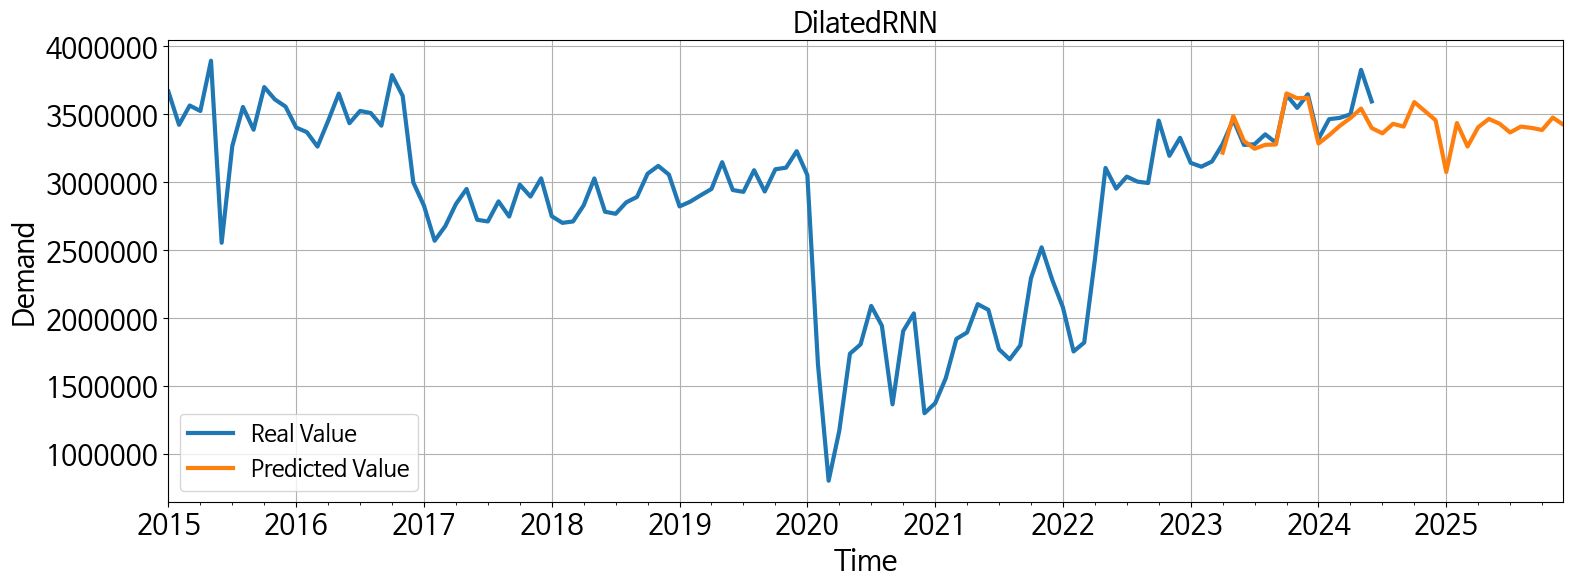

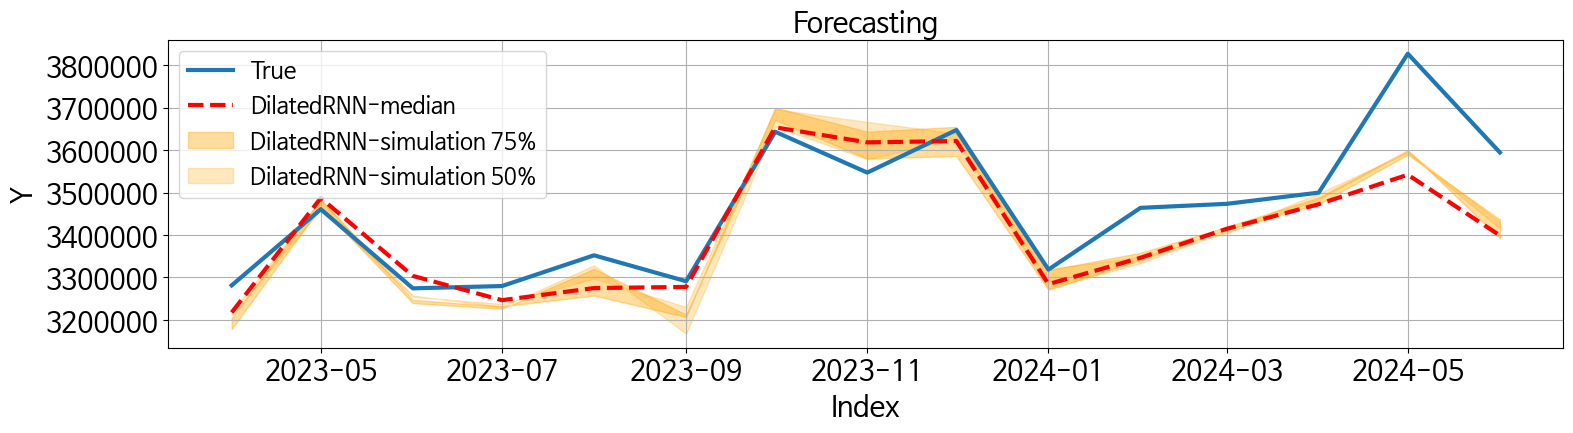

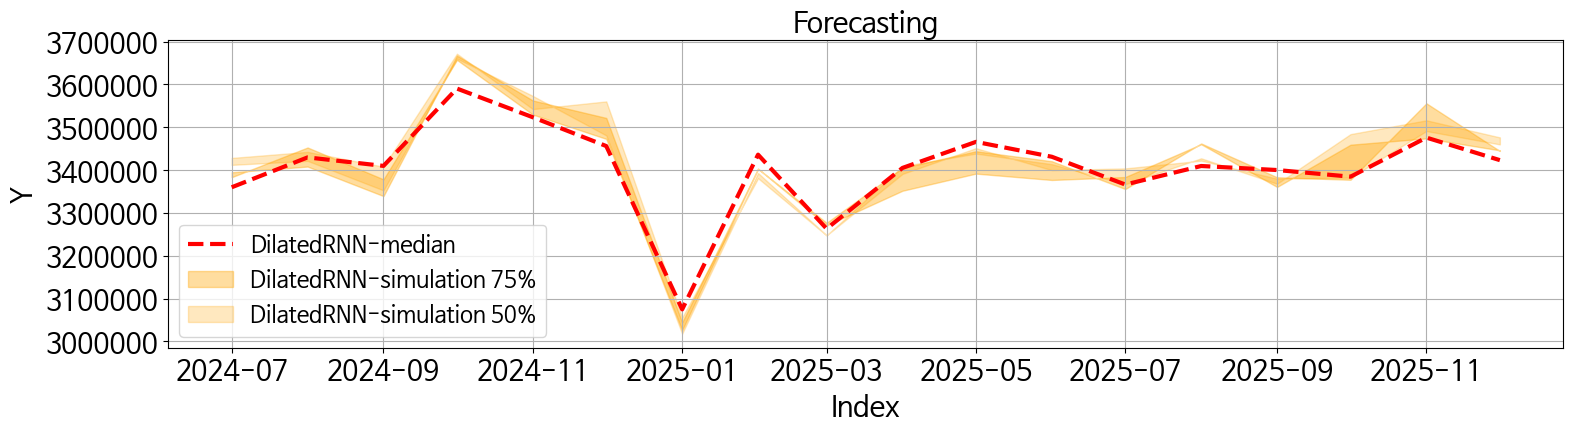

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | rnn_stack       | Sequential    | 1.1 M  | train
4 | context_adapter | Linear        | 77.5 K | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
1.2 M     Trainable params
5         Non-trainable params
1.2 M     Total params
4.928     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

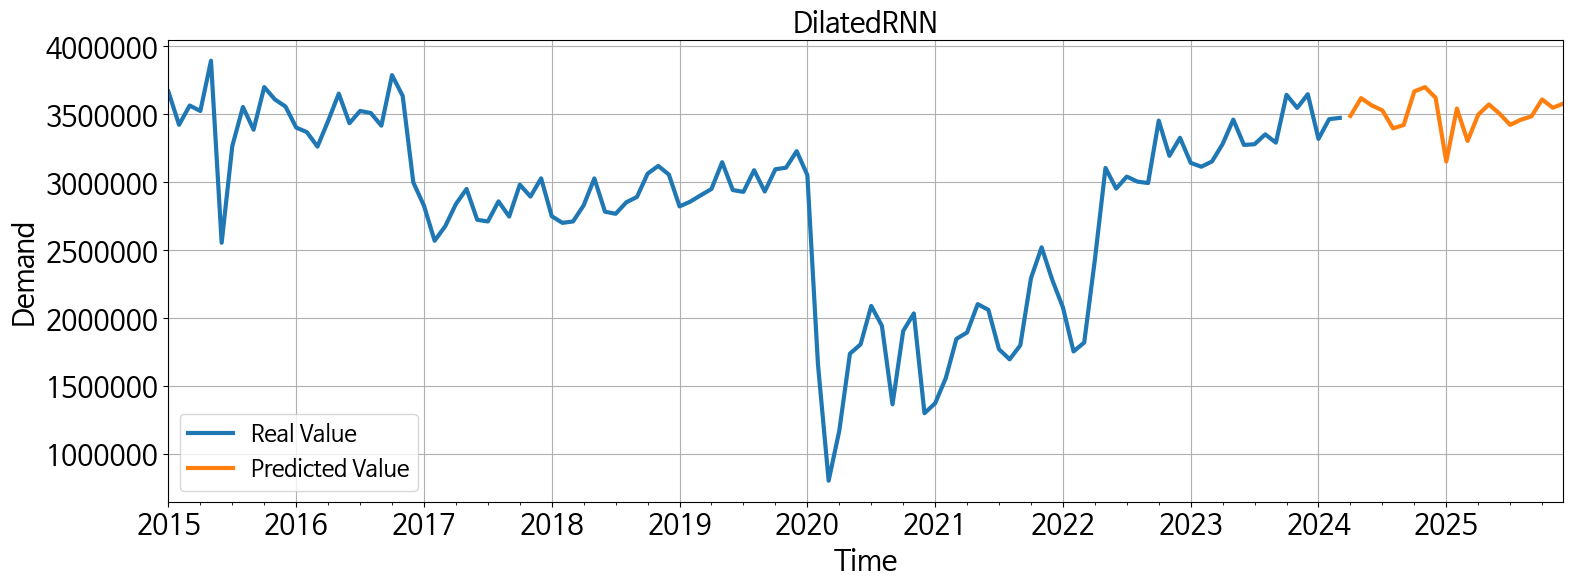

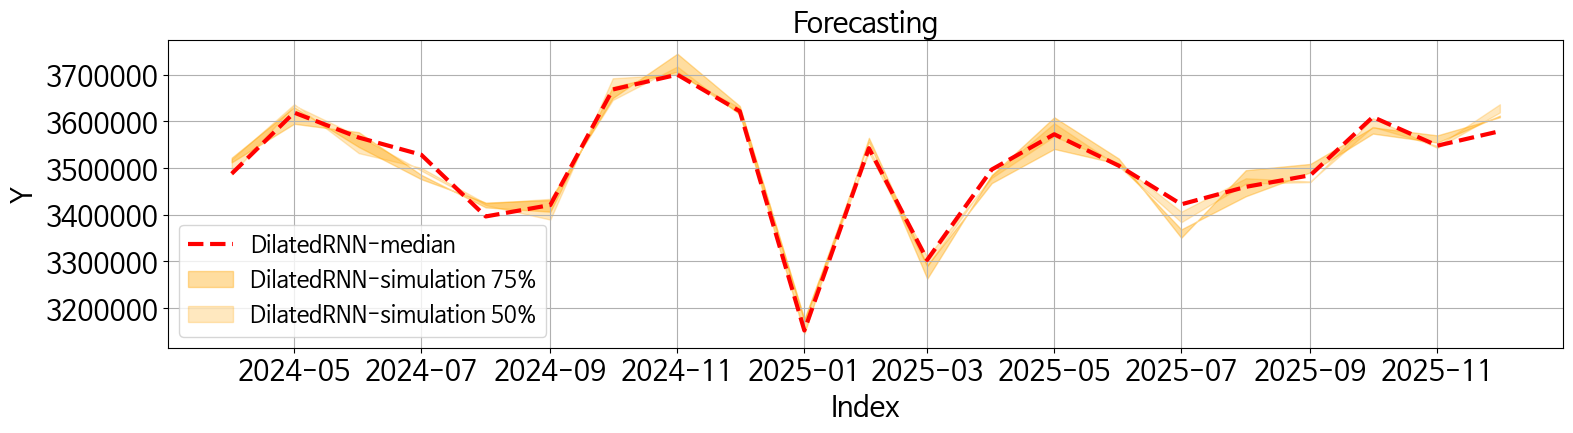

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 516 K  | train
4 | context_adapter | Linear        | 153 K  | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
674 K     Trainable params
5         Non-trainable params
674 K     Total params
2.697     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


전체 경전선


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

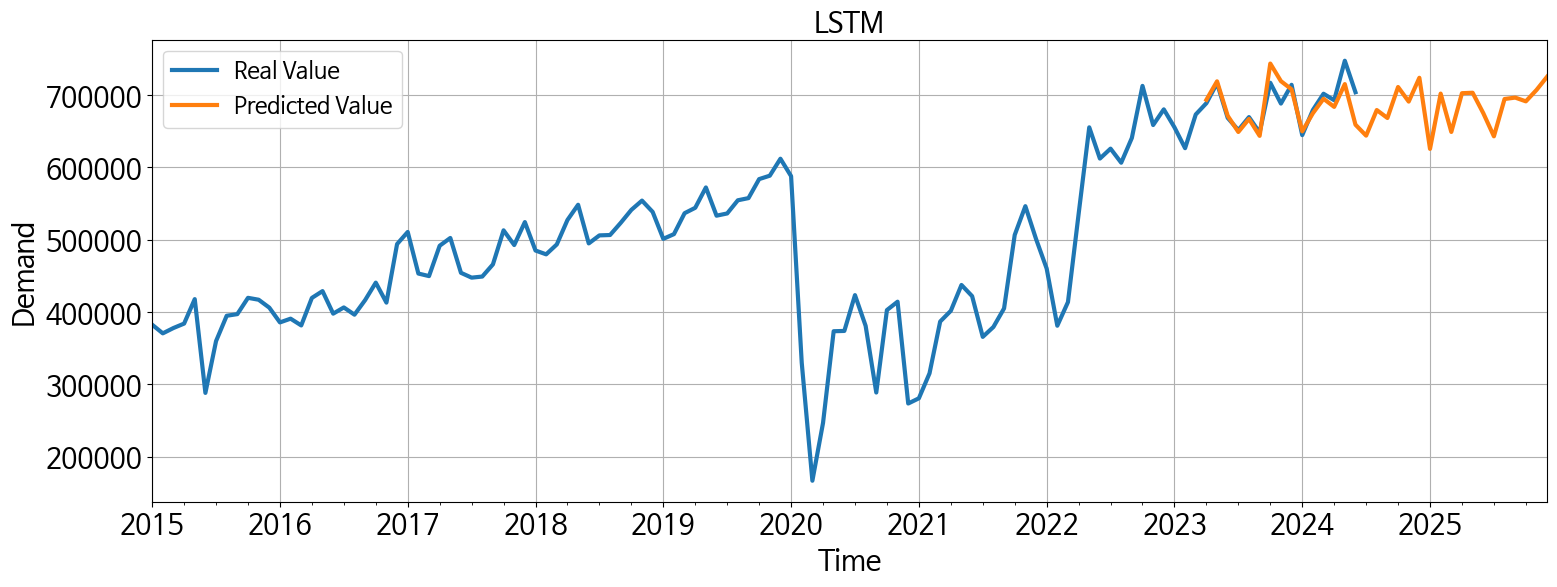

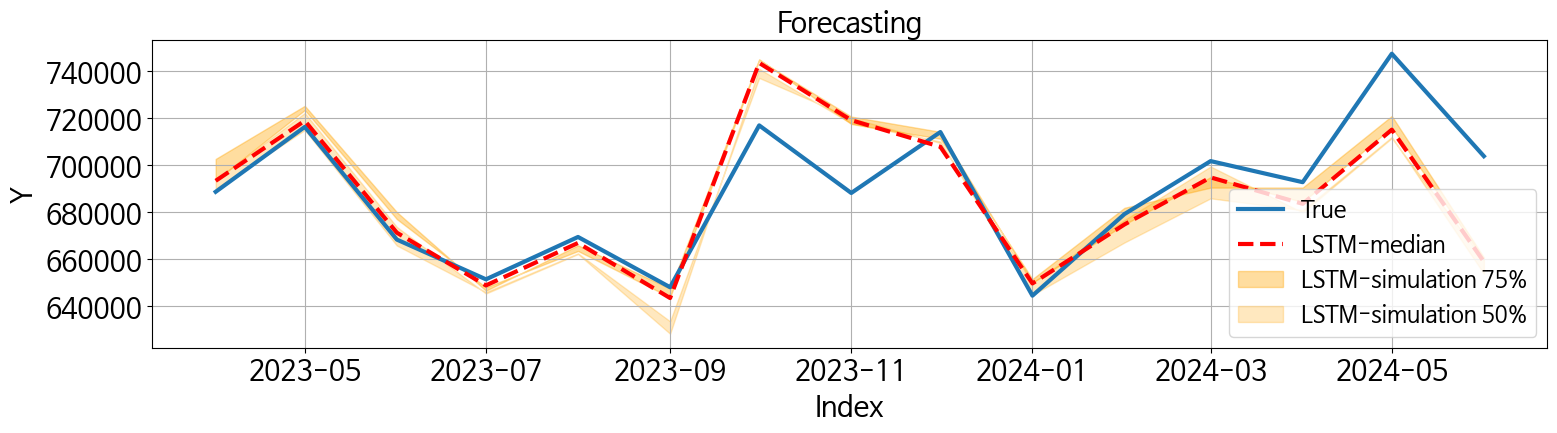

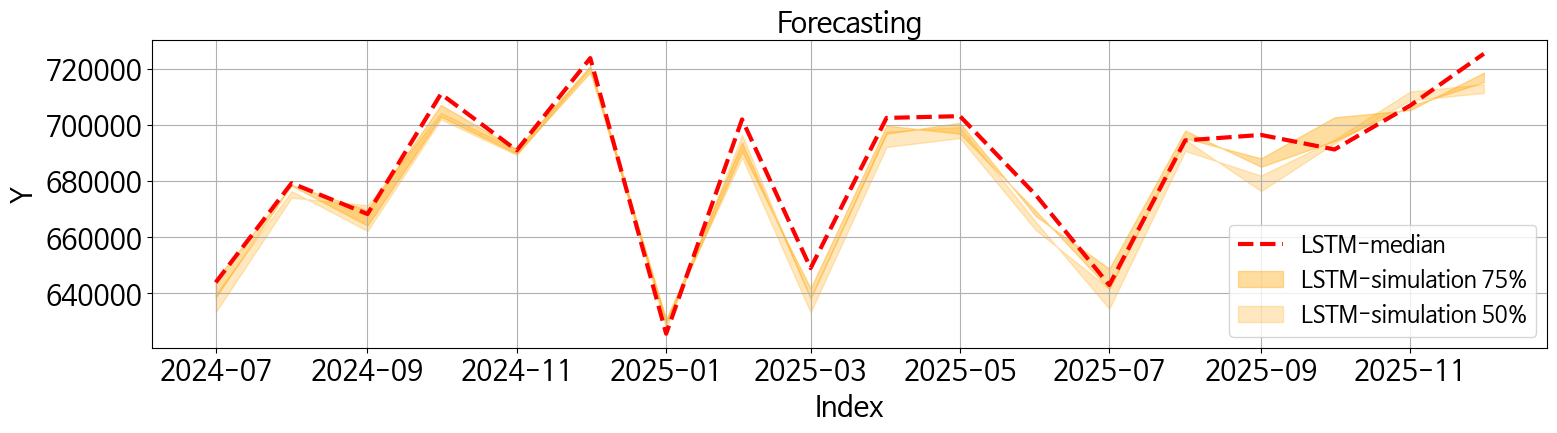

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 516 K  | train
4 | context_adapter | Linear        | 77.5 K | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
598 K     Trainable params
5         Non-trainable params
598 K     Total params
2.393     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

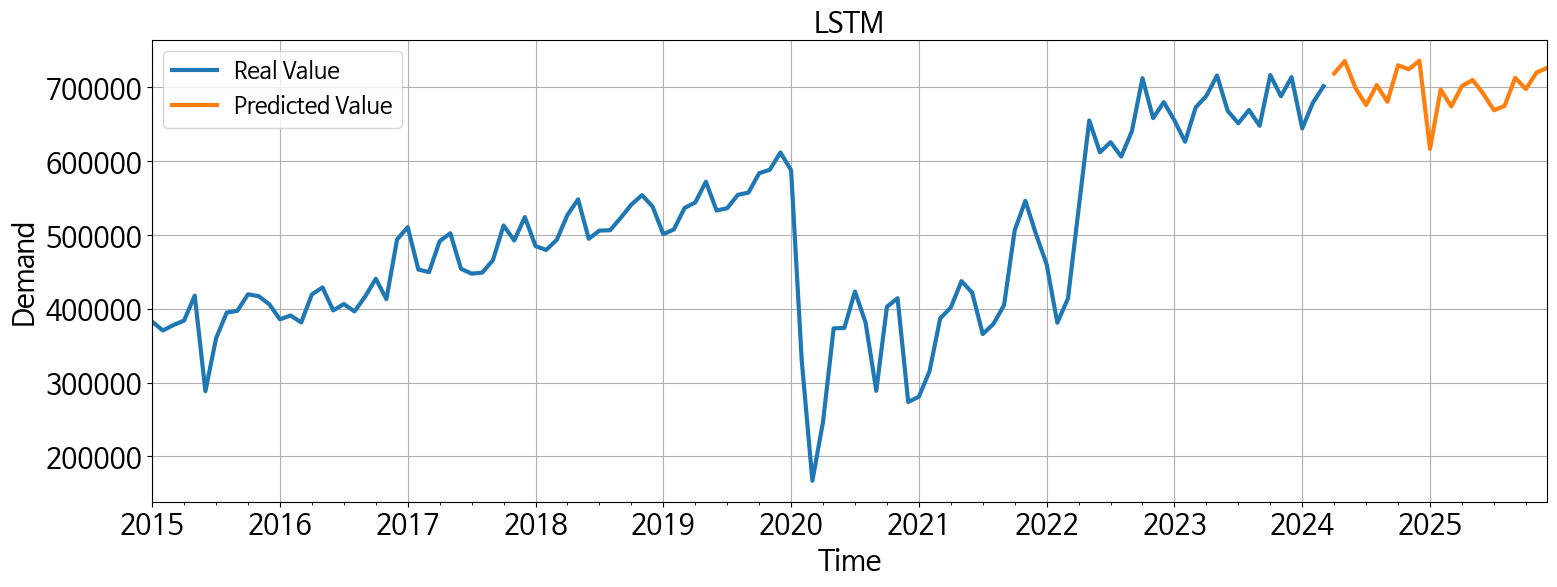

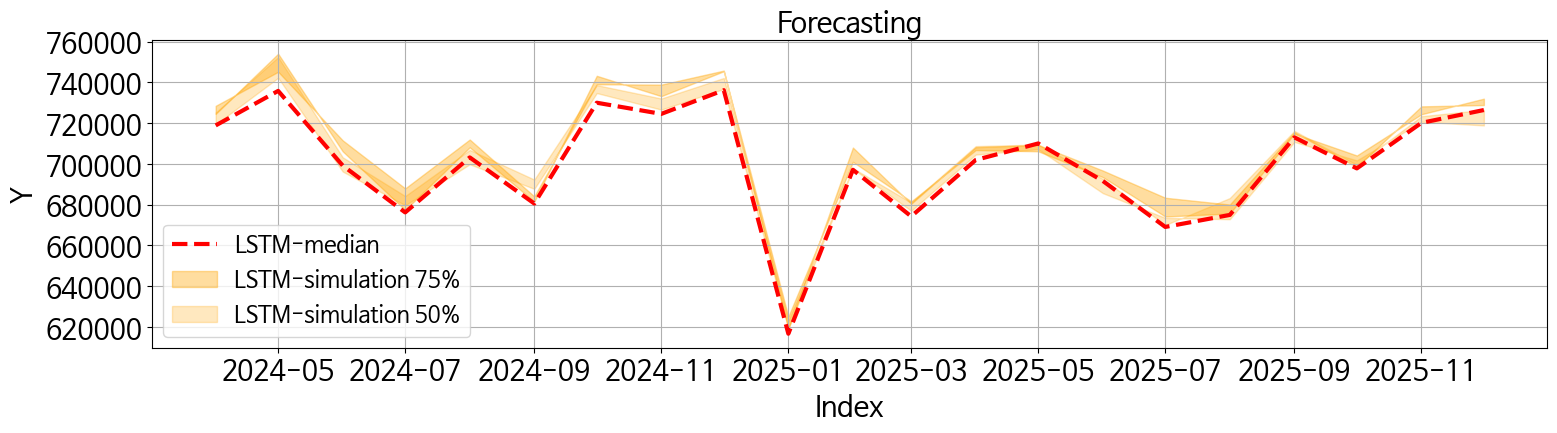

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 506 K  | train
4 | context_adapter | Linear        | 153 K  | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
664 K     Trainable params
5         Non-trainable params
664 K     Total params
2.659     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


전체 동해선


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

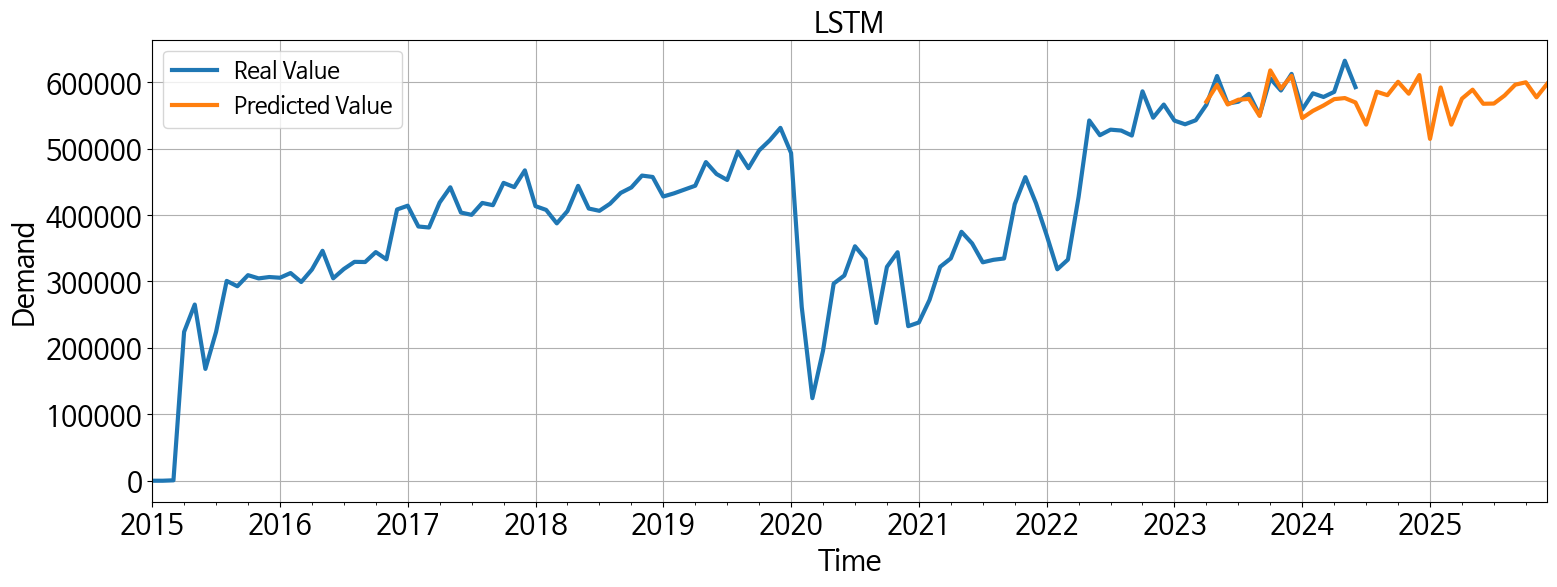

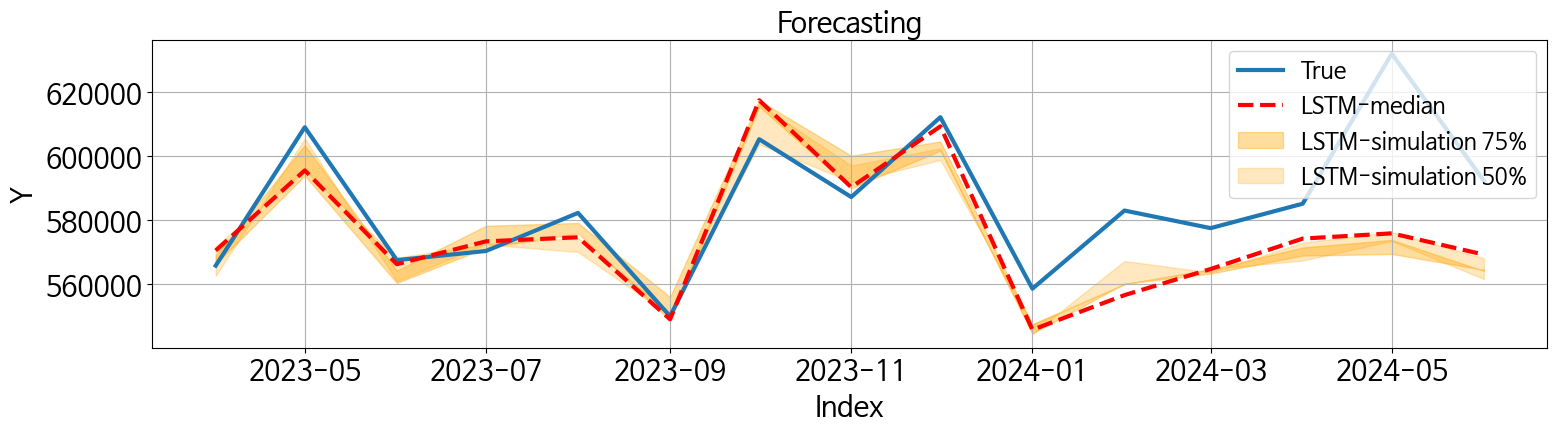

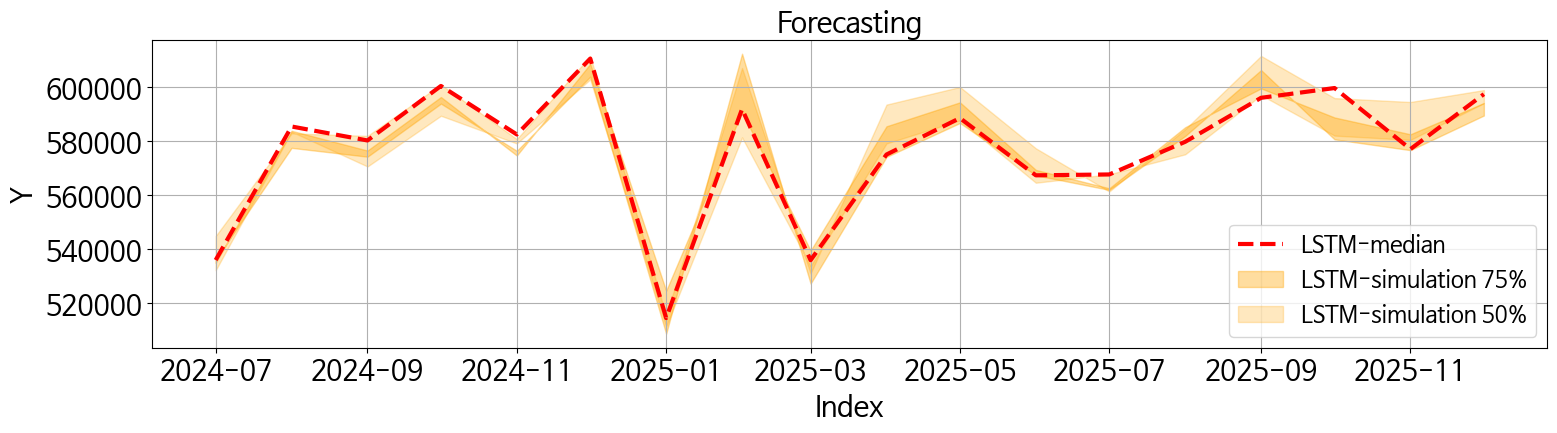

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 506 K  | train
4 | context_adapter | Linear        | 77.5 K | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
588 K     Trainable params
5         Non-trainable params
588 K     Total params
2.355     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

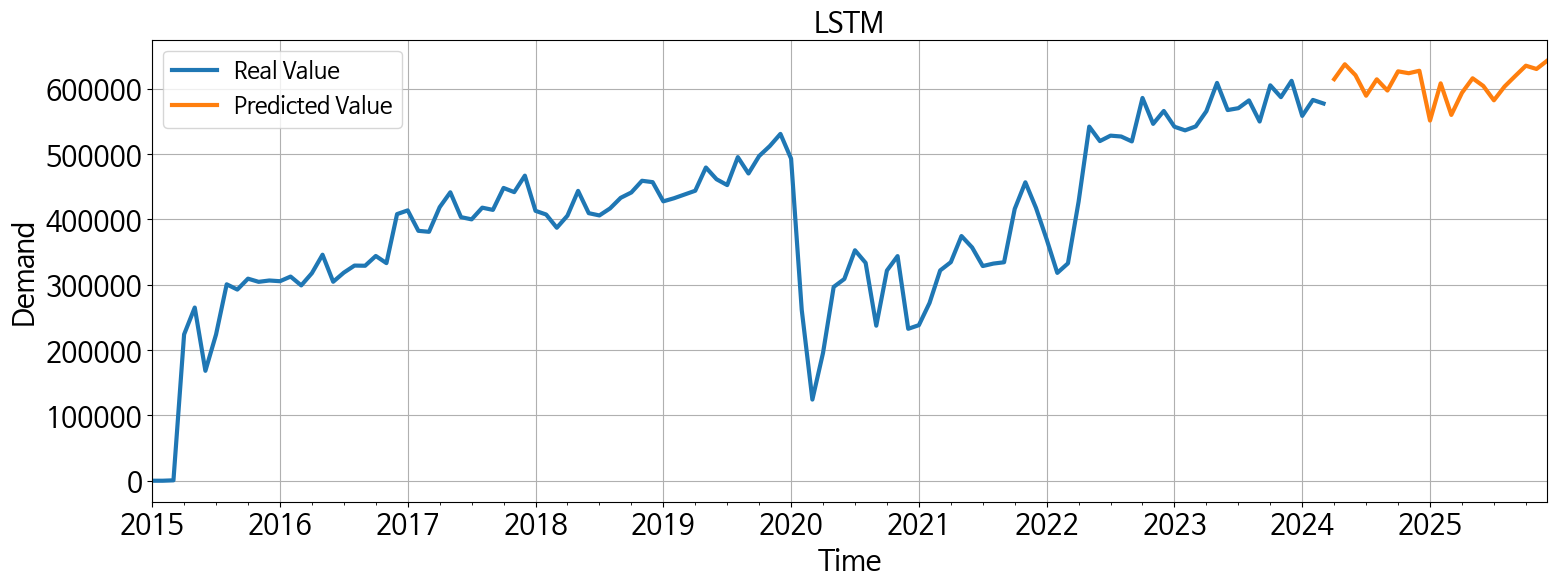

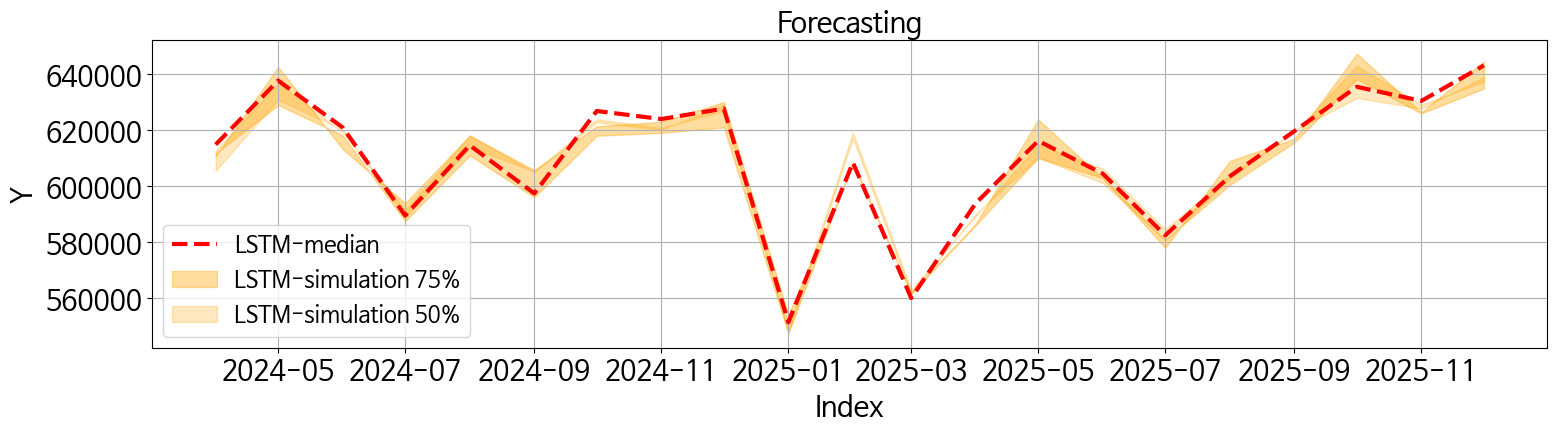

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 506 K  | train
4 | context_adapter | Linear        | 153 K  | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
664 K     Trainable params
5         Non-trainable params
664 K     Total params
2.659     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


전체 전라선


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

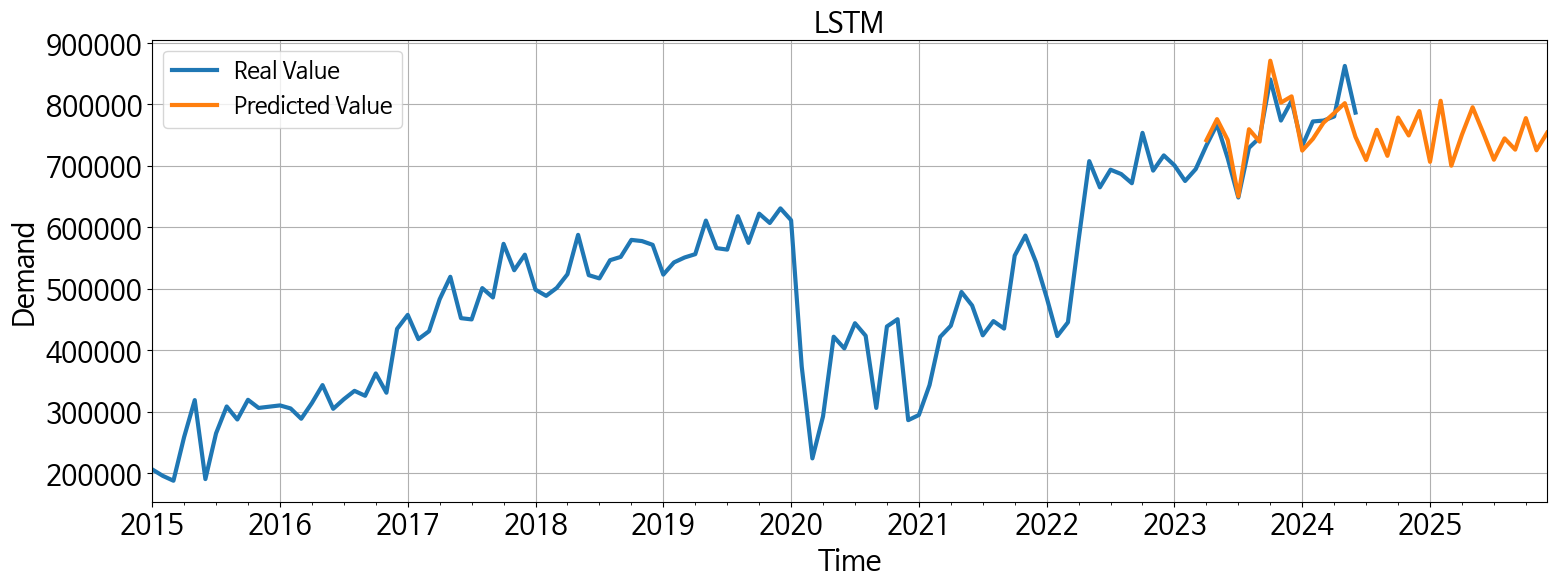

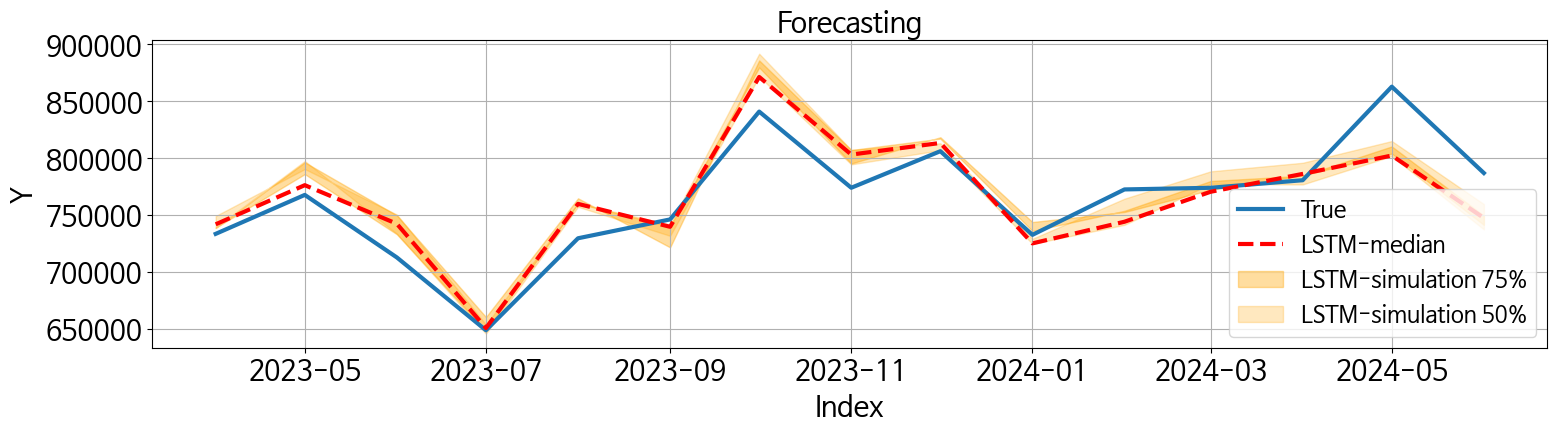

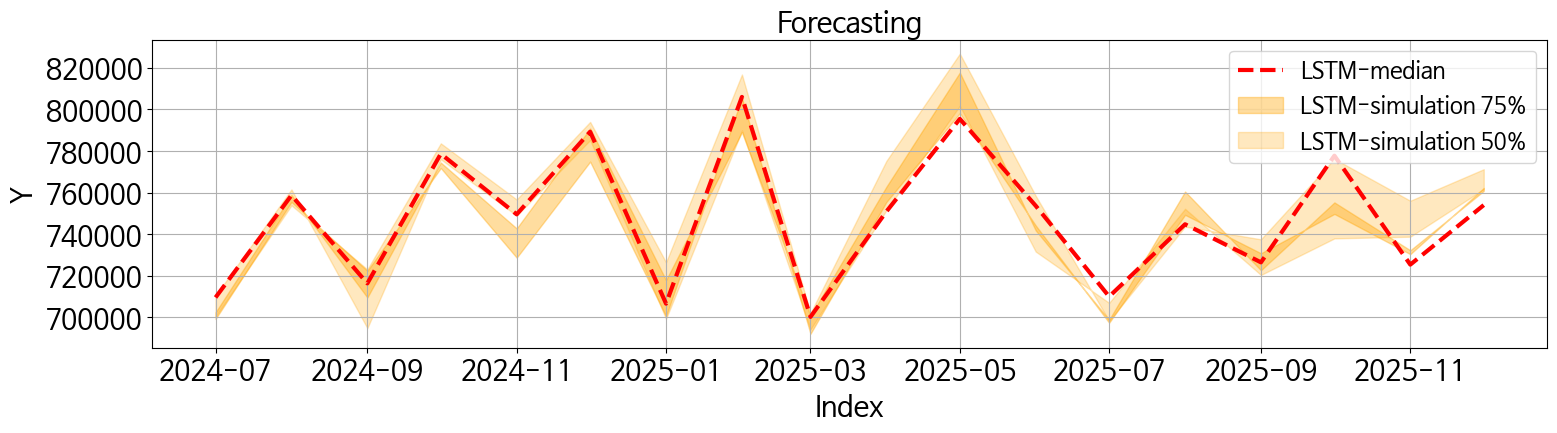

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 506 K  | train
4 | context_adapter | Linear        | 77.5 K | train
5 | mlp_decoder     | MLP           | 4.8 K  | train
----------------------------------------------------------
588 K     Trainable params
5         Non-trainable params
588 K     Total params
2.355     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

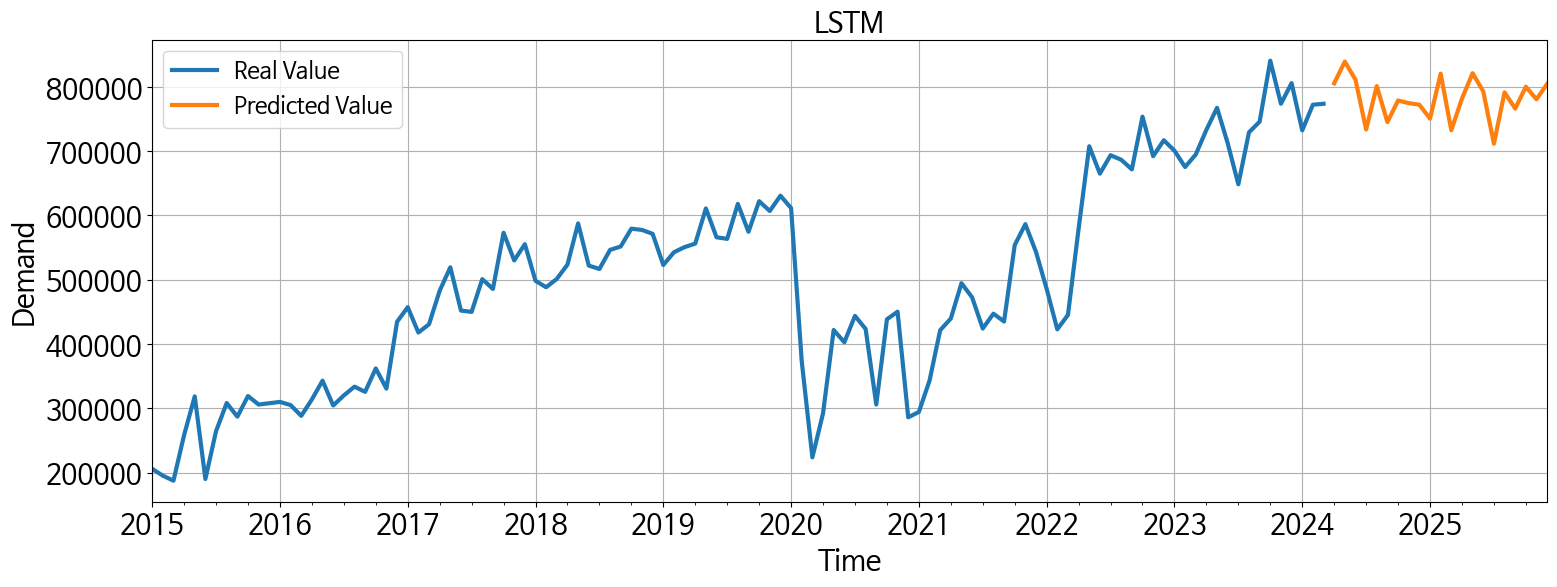

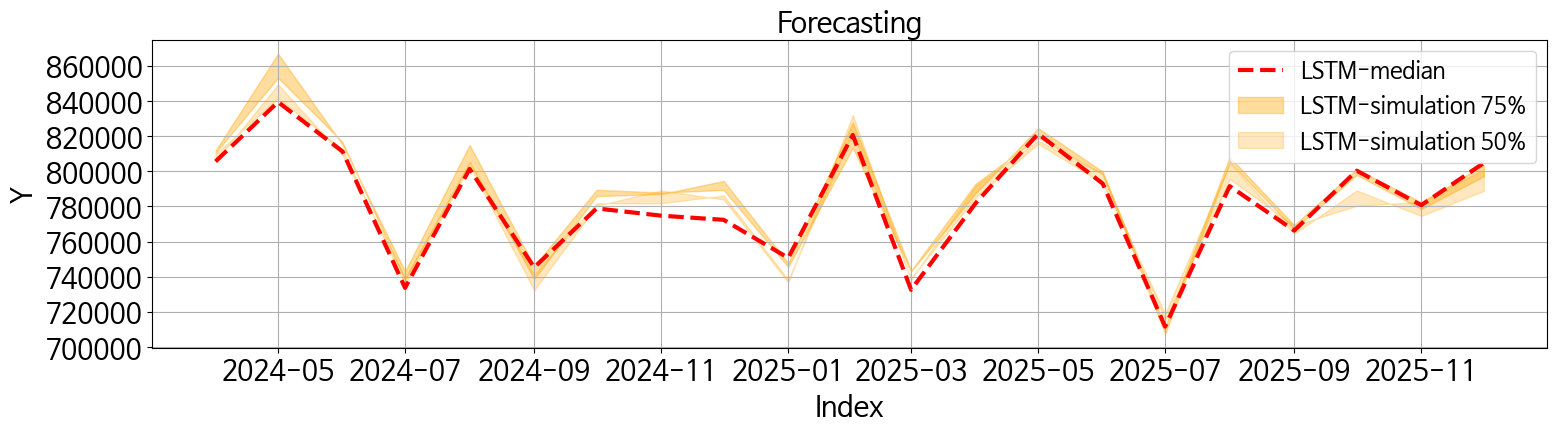

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 337 K  | train
4 | context_adapter | Linear                     | 153 K  | train
5 | mlp_decoder     | MLP                        | 4.8 K  | train
-----------------------------------------------------------------------
495 K     Trainable params
5         Non-trainable params
495 K     Total params
1.983     Total estimated model params size (MB)
37        Modules in train mode
0         Modules

전체 호남선


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

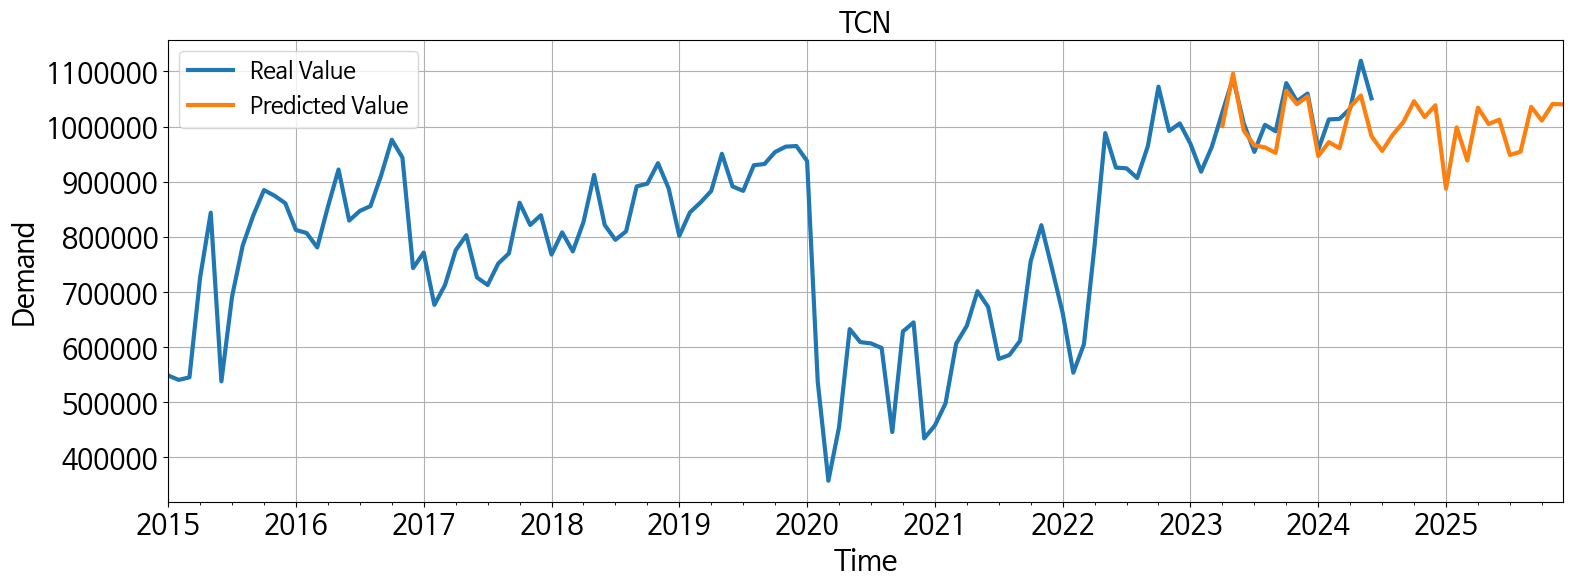

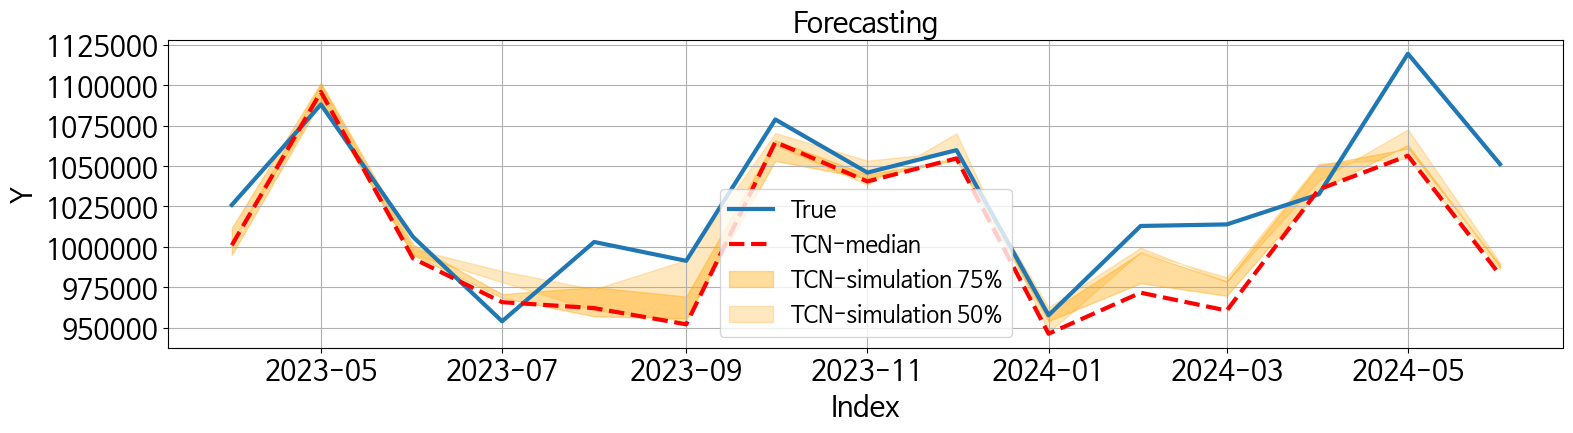

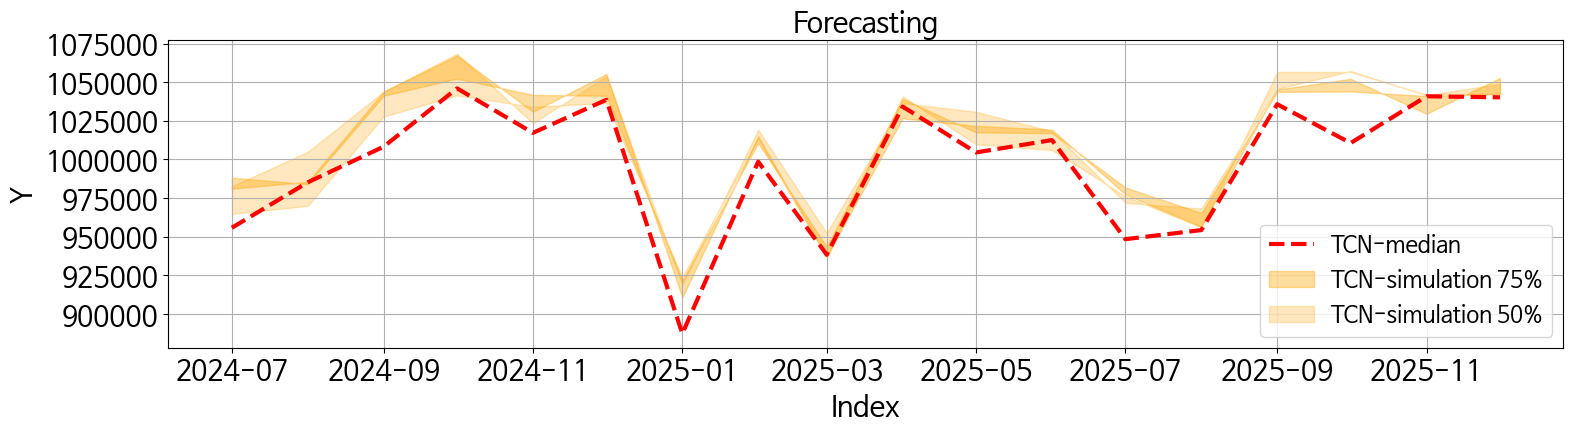

[Kss]: Seed set to 1
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[Kss]: 
  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 337 K  | train
4 | context_adapter | Linear                     | 77.5 K | train
5 | mlp_decoder     | MLP                        | 4.8 K  | train
-----------------------------------------------------------------------
419 K     Trainable params
5         Non-trainable params
419 K     Total params
1.679     Total estimated model params size (MB)
37        Modules in train mode
0         Modules

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[Kss]: `Trainer.fit` stopped: `max_steps=1000` reached.
[Kss]: GPU available: True (cuda), used: True
[Kss]: TPU available: False, using: 0 TPU cores
[Kss]: HPU available: False, using: 0 HPUs
[Kss]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

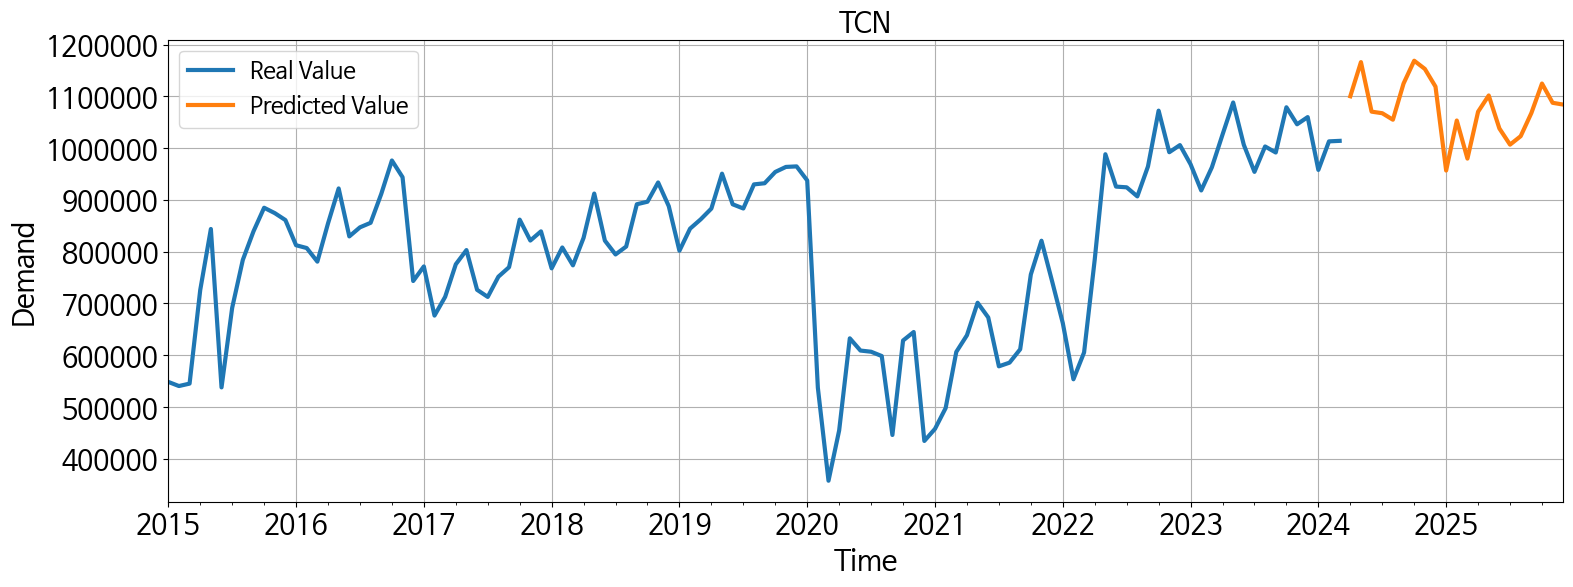

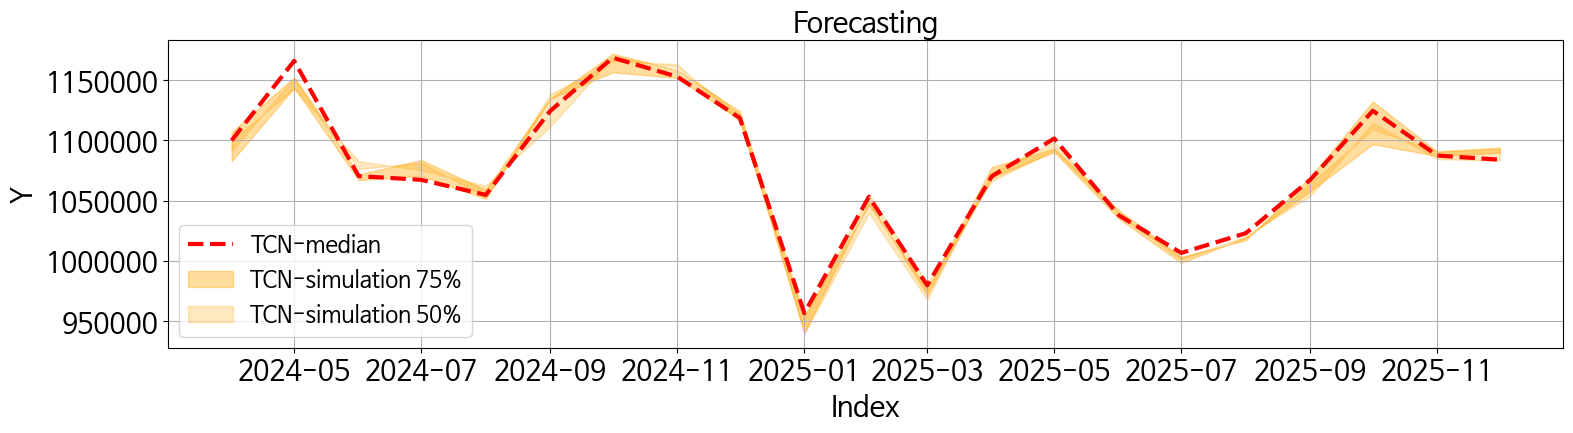

2019년          2024년          2025년  증감율%(2019-2025)  \
주운행선 전체주중주말                                                                 
경부선  전체     3,000,063.8333 3,529,714.5000 3,377,811.2500          12.5913   
     전체     3,000,063.8333 3,529,714.5000 3,473,030.7500          15.7652   
경전선  전체       552,301.5833   694,868.1667   684,489.4375          23.9340   
     전체       552,301.5833   694,868.1667   691,129.4375          25.1362   
동해선  전체       470,230.5833   588,157.6667   574,230.8125          22.1169   
     전체       470,230.5833   588,157.6667   604,090.3750          28.4668   
전라선  전체       580,489.3333   784,707.1667   745,911.6875          28.4971   
     전체       580,489.3333   784,707.1667   779,593.0000          34.2993   
호남선  전체       905,065.5833 1,031,290.3333   992,139.5000           9.6207   
     전체       905,065.5833 1,031,290.3333 1,049,350.0000          15.9419   

             증감율%(2024-2025)      알고리즘순위  
주운행선 전체주중주말                               
경부선  전체              -4.3036  DilatedRNN  
     전체              -1.6059  DilatedRNN  
경전선  전체              -1.4936        LSTM  
     전체              -0.5380        LSTM  
동해선  전체              -2.3679        LSTM  
     전체               2.7089        LSTM  
전라선  전체              -4.9439        LSTM  
     전체              -0.6517        LSTM  
호남선  전체              -3.7963         TCN  
     전체               1.7512         TCN

In [25]:
# 최적예측
Y_pred_final, Y_eval_final = pd.DataFrame(), pd.DataFrame()
for target_line in lines:
    for target_dow in dows:
        print(target_dow, target_line)

        # 방향
        opt_direct = Y_direct_top[(Y_direct_top['전체주중주말'] == target_dow) & (Y_direct_top['주운행선'] == target_line)]
        ## 변수구분
        Y_colname = '승차인원수'
        X_delete = ['전체주중주말', '주운행선']
        if list(opt_direct['변수수'])[0] == Y_direct_total['변수수'].unique()[0]:
            LAG_LENGTH = None
            X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
                          '공급좌석합계수', '승차율', '열차운행횟수']
        elif list(opt_direct['변수수'])[0] == Y_direct_total['변수수'].unique()[2]:
            LAG_LENGTH = 12
            X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
                          '공급좌석합계수', '승차율', '열차운행횟수']          
        elif list(opt_direct['변수수'])[0] == Y_direct_total['변수수'].unique()[1]:
            LAG_LENGTH = None
            X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
                          '공급좌석합계수', '승차율', '열차운행횟수',
                          '사망자수', '접종시작자수', '격리된자수', '정부대응정도', 
                          '확진자수', '접종완료자수', '코로나진행정도', '국가이동제한정도']
        elif list(opt_direct['변수수'])[0] == Y_direct_total['변수수'].unique()[3]:
            LAG_LENGTH = 12
            X_col_FUTR = ['일수', '주말수', '주중수', '공휴일수', '명절수',
                          '공급좌석합계수', '승차율', '열차운행횟수',
                          '사망자수', '접종시작자수', '격리된자수', '정부대응정도', 
                          '확진자수', '접종완료자수', '코로나진행정도', '국가이동제한정도']
        X_col_HISTR = 'auto'
        X_col_STATIC_ML = []
        X_col_STATIC_DL = None
        ## 기간구분
        DATE_SLPITS = ['2023-03-31', '2024-06-30']
        ## 알고리즘 방향
        ALGOS = list(opt_direct['알고리즘'])

        # 데이터로딩 및 전처리
        df_sub = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
        df_train, df_validate, df_test, X_colname = preprocessing_ktx(df_sub, Y_colname=Y_colname, X_delete=X_delete,
                                                                      lag_length=LAG_LENGTH, date_splits=DATE_SLPITS)

        # 모델링
        if ALGOS[0] in ALGOS_ML:
            ALGOS_FINAL = ALGOS
            model_ml, Y_pred_ml = modeling_MLForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
                                                      Y_colname=Y_colname, 
                                                      X_col_FUTR=X_col_FUTR, X_col_STATIC=X_col_STATIC_ML,
                                                      ALGORITHMS=ALGOS_FINAL, CONFIG_CUSTOM=CONFIG_CUSTOM_ML,
                                                      INTERVAL_LEVELS=LEVELS, INTERVAL_WINDOW=N_WINDOWS,
                                                      RANDOM_STATE=RANDOM_STATE, VERBOSITY=VERBOSITY)
            Y_pred = Y_pred_ml
        else:
            ALGOS_FINAL = [algo for algo in ALGOS_DL if str(algo).split("'>")[0].split('.')[-1] == ALGOS[0]]
            model_dl, Y_pred_dl = modeling_NeuralForecast(df_train, pd.concat([df_validate, df_test], axis=0), 
                                                          Y_colname=Y_colname, 
                                                          X_col_FUTR=X_col_FUTR, X_col_HISTR=X_col_HISTR, X_col_STATIC=X_col_STATIC_DL,
                                                          ALGORITHMS=ALGOS_FINAL, CONFIG_CUSTOM=CONFIG_CUSTOM_DL)
            Y_pred = Y_pred_dl

        # 평가/검증
        Y_valpred, Y_tepred = Y_pred.iloc[:df_validate.shape[0],:], Y_pred.iloc[df_validate.shape[0]:,:]
        ## Prediction plot
        evaluation_time_PredPlot(pd.concat([df_train[Y_colname], df_validate[Y_colname]], axis=0), 
                                 pd.concat([Y_valpred[ALGOS], Y_tepred[ALGOS]], axis=0), 
                                 Y_pred_index=True, 
                                 title=ALGOS[0], xlabel='Time', ylabel='Demand', visual_package='matolotlib')
        evaluation_reg_PredPlot_DF(Y_valpred.iloc[:,1:], levels=True)
        evaluation_reg_PredPlot_DF(Y_tepred.iloc[:,2:], levels=True)
        ## 저장
        Y_real = pd.concat([df_train, df_validate, df_test], axis=0)[Y_colname]
        Y_eval = evaluation_year_ktx(target_line, target_dow, Y_real, Y_pred, year_prediction, year_comparison)
        Y_eval_final = pd.concat([Y_eval_final, Y_eval], axis=0)
        Y_pred_final = pd.concat([Y_pred_final, Y_tepred[ALGOS]], axis=1)

        # 데이터로딩 및 전처리
        ## 기간구분
        DATE_SLPITS = ['2024-03-31']
        df_train, df_validate, df_test, X_colname = preprocessing_ktx(df_sub, Y_colname=Y_colname, X_delete=X_delete,
                                                                      lag_length=LAG_LENGTH, date_splits=DATE_SLPITS)

        # 모델링
        if ALGOS[0] in ALGOS_ML:
            ALGOS_FINAL = ALGOS
            model_ml, Y_pred_ml = modeling_MLForecast(df_train, df_test, 
                                                      Y_colname=Y_colname, 
                                                      X_col_FUTR=X_col_FUTR, X_col_STATIC=X_col_STATIC_ML,
                                                      ALGORITHMS=ALGOS_FINAL, CONFIG_CUSTOM=CONFIG_CUSTOM_ML,
                                                      INTERVAL_LEVELS=LEVELS, INTERVAL_WINDOW=N_WINDOWS,
                                                      RANDOM_STATE=RANDOM_STATE, VERBOSITY=VERBOSITY)
            Y_pred = Y_pred_ml
        else:
            ALGOS_FINAL = [algo for algo in ALGOS_DL if str(algo).split("'>")[0].split('.')[-1] == ALGOS[0]]
            model_dl, Y_pred_dl = modeling_NeuralForecast(df_train, df_test, 
                                                          Y_colname=Y_colname, 
                                                          X_col_FUTR=X_col_FUTR, X_col_HISTR=X_col_HISTR, X_col_STATIC=X_col_STATIC_DL,
                                                          ALGORITHMS=ALGOS_FINAL, CONFIG_CUSTOM=CONFIG_CUSTOM_DL)
            Y_pred = Y_pred_dl

        # 평가/검증
        Y_tepred = Y_pred
        ## Prediction plot
        evaluation_time_PredPlot(df_train[Y_colname], Y_tepred[ALGOS], 
                                 Y_pred_index=True, 
                                 title=ALGOS[0], xlabel='Time', ylabel='Demand', visual_package='matolotlib')
        evaluation_reg_PredPlot_DF(Y_tepred.iloc[:,2:], levels=True)     
        ## 저장
        Y_eval = evaluation_year_ktx(target_line, target_dow, Y_real, Y_pred, year_prediction, year_comparison)
        Y_eval_final = pd.concat([Y_eval_final, Y_eval], axis=0)
        Y_pred_final = pd.concat([Y_pred_final, Y_tepred[ALGOS]], axis=1)
## 출력
with pd.ExcelWriter(os.path.join(os.getcwd(), 'Result', save_name_final), engine='xlsxwriter') as writer:
    Y_eval_final.to_excel(writer, sheet_name='Evaluation_byYear')
    Y_pred_final.to_excel(writer, sheet_name='Forecasting')
Y_eval_final

# Others

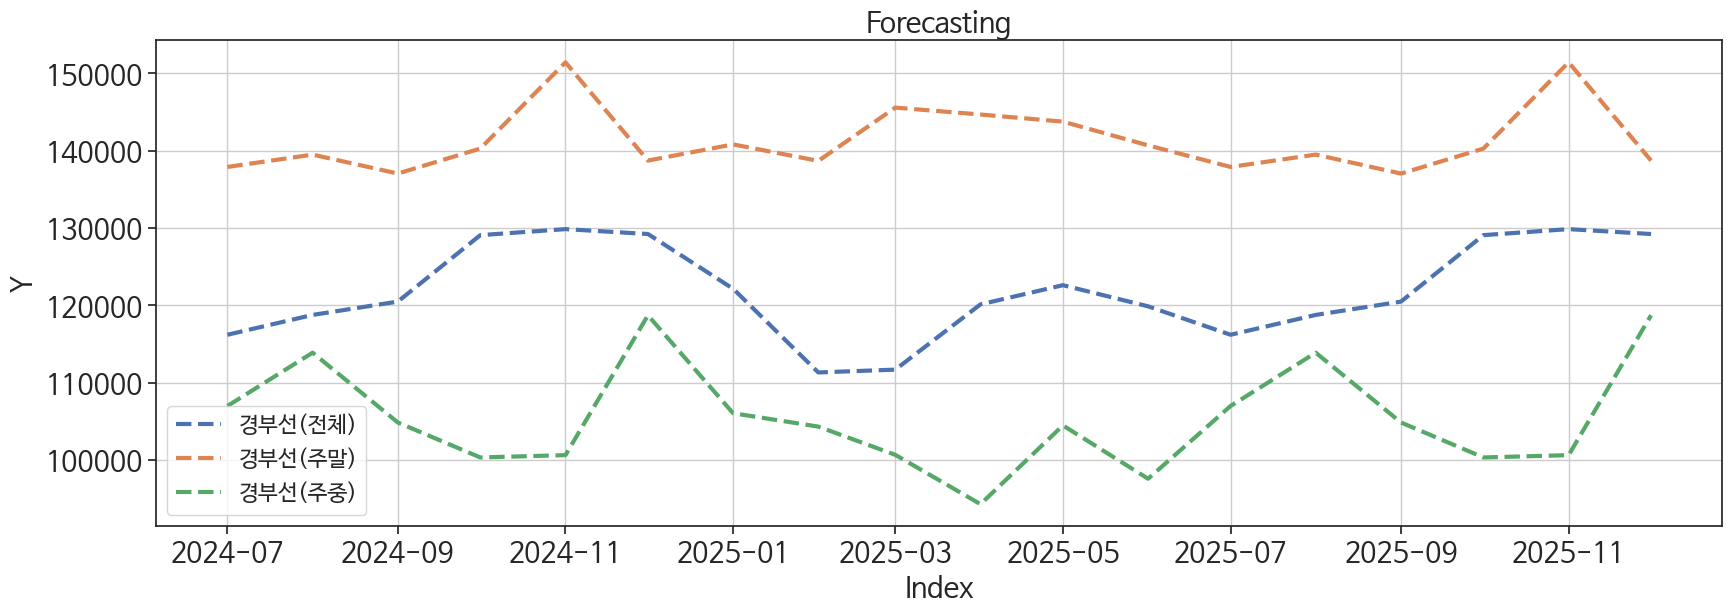

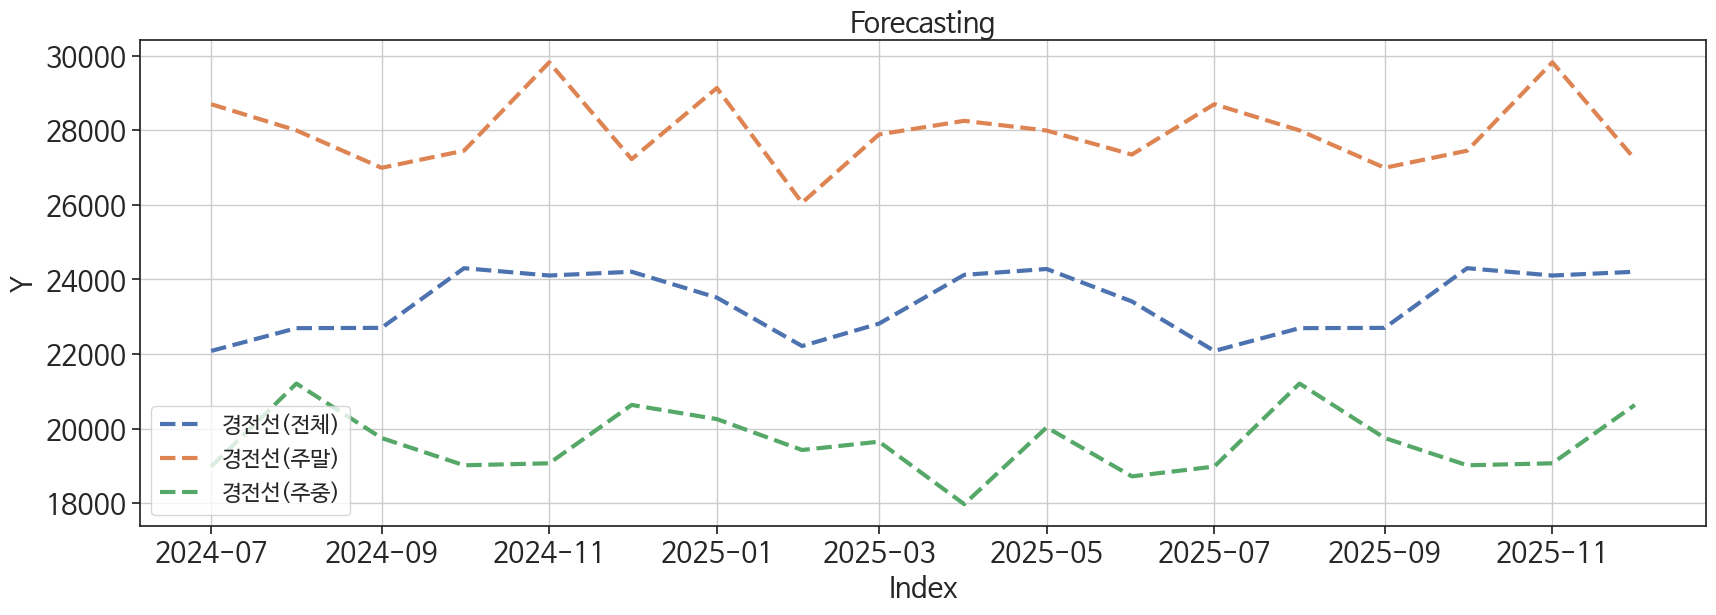

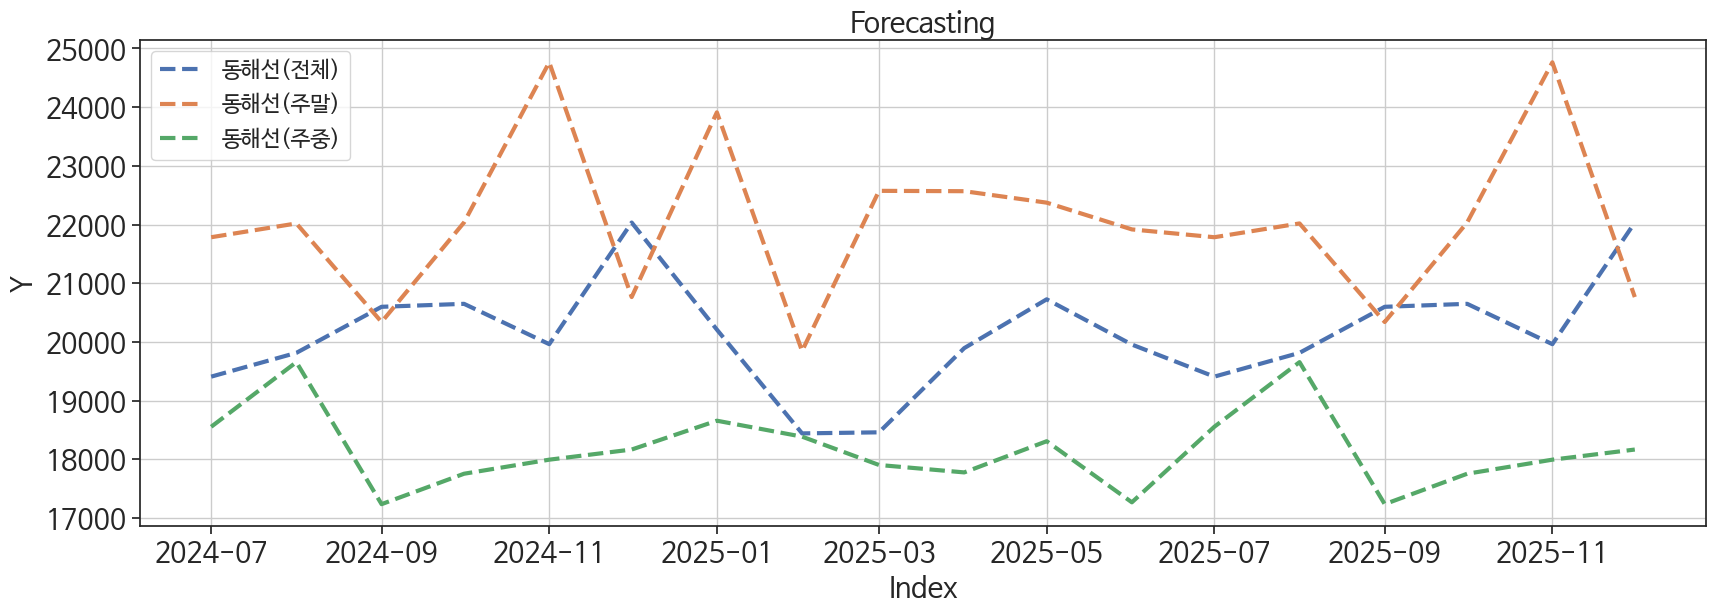

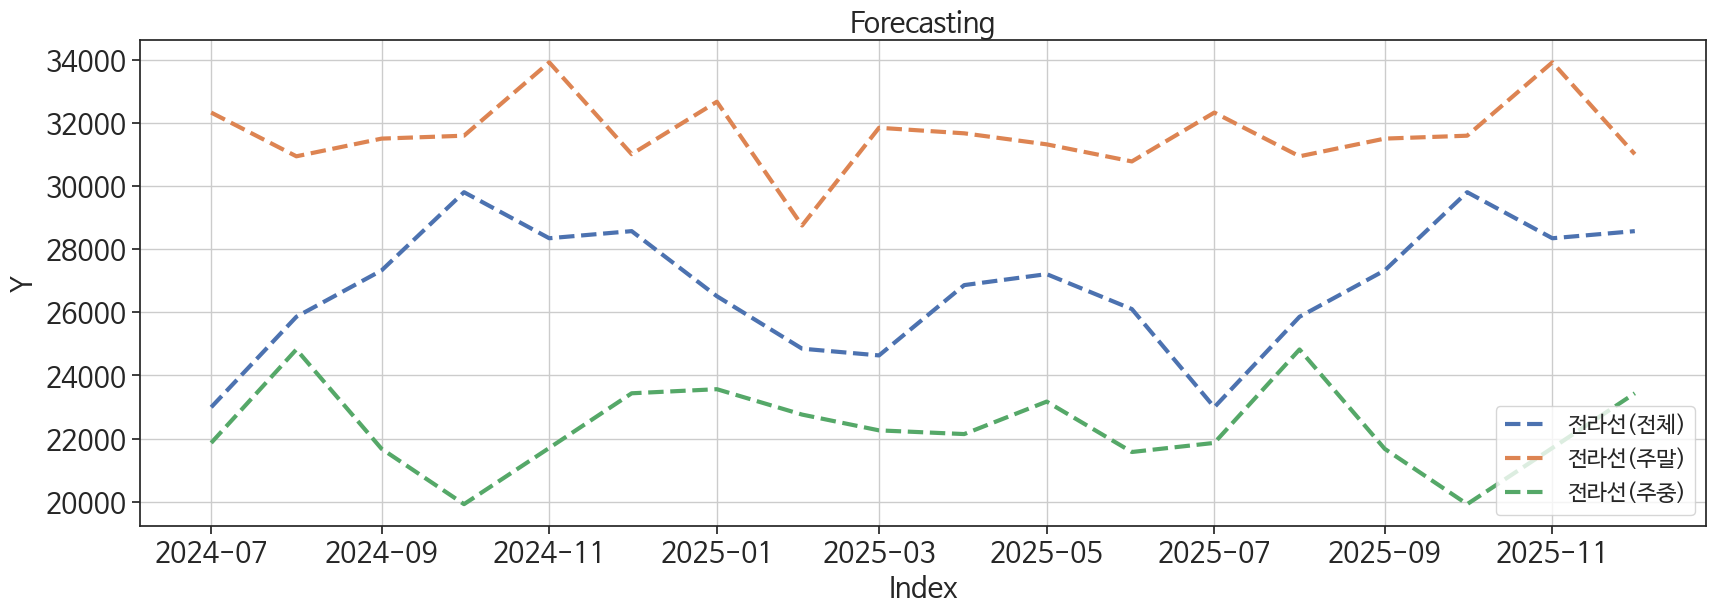

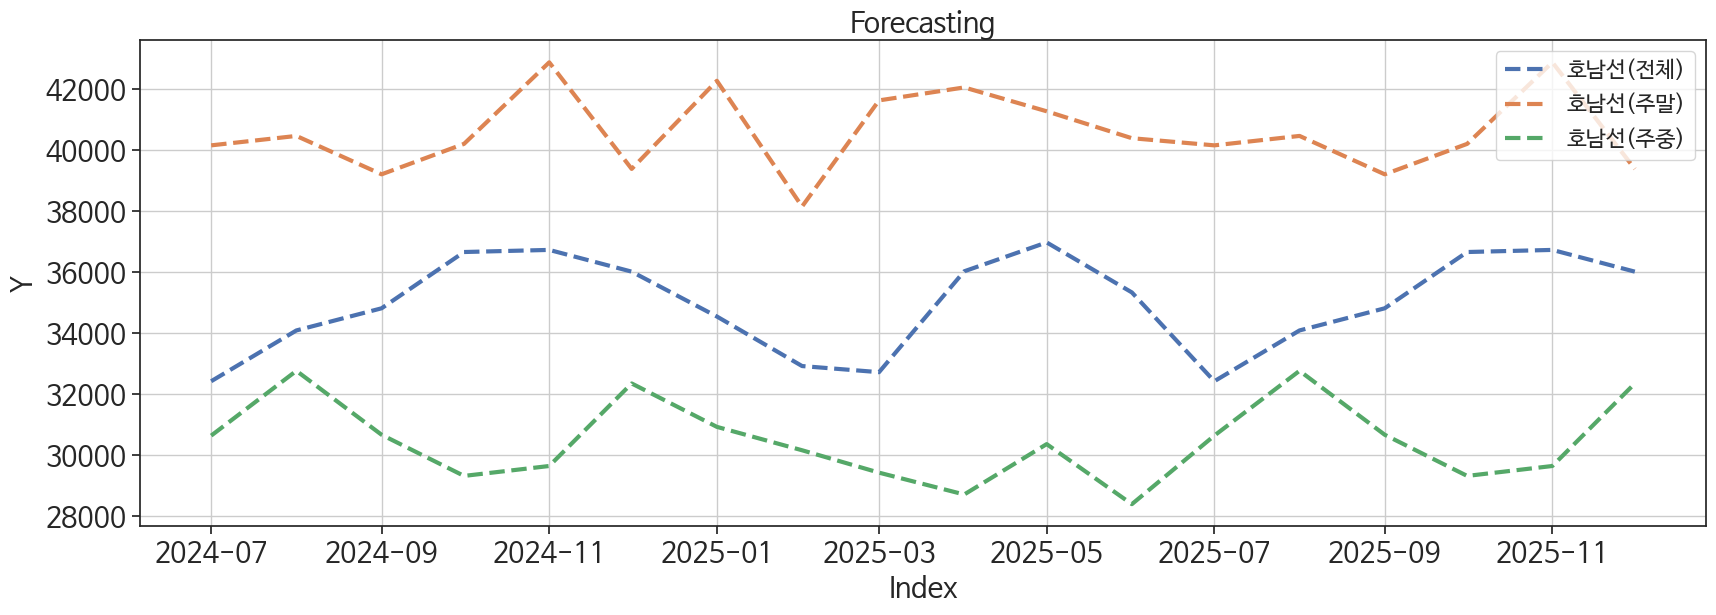

In [44]:
# # 라인별 시각화
# ## evaluation_reg_PredPlot_DF 함수 신뢰구간 없을 경우 필터링 삭제 필요
# df_pred_line = df_pred.copy()
# df_pred_line.columns = [combi[0] + "(" + combi[1] + ")" for combi in product(lines,dows)]

# for target_line in lines:
#     df_sub = df_pred_line[[col for col in df_pred_line.columns if col.split('(')[0] == target_line]]
#     evaluation_reg_PredPlot_DF(df_sub.iloc[3:,:], levels=False)